# Paraphrase Detection Using Feature-Based Similarity Models

## 1. Introduction

Paraphrase detection is a fundamental problem in Natural Language Processing (NLP) that aims to determine whether two sentences express the same meaning despite potential differences in wording, structure, or lexical choice. This task plays a critical role in real-world applications such as question answering, information retrieval, duplicate question detection, plagiarism detection, and text summarization.

In this notebook, we study the paraphrase detection problem using the Quora Question Pairs (QQP) dataset and approach it from a classical, feature-based machine learning perspective. Instead of relying on large pretrained language models, we systematically design and evaluate a range of interpretable similarity features, including lexical overlap, character-level similarity, structural length features, and distributional semantic representations derived from word embeddings trained from scratch.

We build a configurable experimental framework that allows us to combine different feature sets, feature extractor configurations, and classification algorithms into complete pipelines. Each pipeline is evaluated using standard classification metrics such as accuracy, precision, recall, and F1 score, as well as efficiency metrics including training and inference time. To better understand model behavior beyond aggregate scores, we also perform confusion-matrix–driven analysis and feature-level error analysis on selected pipelines.

Through this exploration, the notebook aims to answer the following questions:
- How effective are classical similarity-based features for paraphrase detection?
- How do different feature combinations trade off accuracy and efficiency?
- What types of paraphrase errors are difficult to capture with surface-level and shallow semantic features?

The results provide insight into the strengths and limitations of traditional NLP approaches and motivate directions for future work, such as pretrained sentence encoders and more expressive alignment-based models.


### 1.1. Install and Import Libraries

In [ ]:
!pip install datasets
!pip install gensim

In [ ]:
# ==================================================
# 1. Standard Library
# ==================================================
import json
import re
import time
from pathlib import Path

# ==================================================
# 2. Core Third-Party Libraries
# ==================================================
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

# ==================================================
# 3. NLP & Data Loading
# ==================================================
from datasets import load_dataset
from gensim.models import FastText, Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# ==================================================
# 4. Model Selection & Pipelines
# ==================================================
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ==================================================
# 5. Machine Learning Models
# ==================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier

# ==================================================
# 6. Evaluation Metrics
# ==================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# ==================================================
# 7. Utilities
# ==================================================
import itertools

## 2. Data Preparation

**Source:** https://huggingface.co/datasets/AlekseyKorshuk/quora-question-pairs

The Quora Question Pairs (QQP) dataset is a widely used benchmark for paraphrase detection and semantic similarity tasks. It consists of pairs of questions collected from the Quora platform, where the goal is to determine whether two questions are semantically equivalent, i.e., whether they ask the same thing using different wording.

Each data instance contains two natural language questions and a binary label:
- **1 (duplicate / paraphrase):** the two questions have the same meaning.
- **0 (non-duplicate):** the questions are semantically different.

### Dataset Structure

Each row in the dataset includes the following fields:
- `qid1`, `qid2`: unique identifiers for the two questions.
- `question1`: the first question in the pair.
- `question2`: the second question in the pair.
- `is_duplicate`: binary label indicating whether the two questions are paraphrases.

The dataset contains a large number of question pairs with diverse linguistic variations, including synonym substitutions, paraphrasing through reordering, and changes in grammatical structure. At the same time, it also includes challenging negative examples where questions share significant lexical overlap but differ in intent or meaning.

### Why QQP is Suitable for This Project

The QQP dataset is particularly well suited for studying feature-based paraphrase detection because:
- It naturally exhibits a wide range of lexical and structural variation.
- It includes many hard negative cases where surface-level similarity is misleading.
- It allows evaluation of both precision-oriented and recall-oriented models.
- It has become a standard benchmark, making results easy to interpret and compare.

In this notebook, we use QQP as a controlled environment to evaluate how far classical NLP techniques—such as TF-IDF similarity, lexical overlap measures, and embedding-based sentence representations trained from scratch—can go in solving the paraphrase detection problem without relying on large pretrained language models.


### 2.1. Load Dataset

In [55]:
dataset = load_dataset("AlekseyKorshuk/quora-question-pairs")

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'],
        num_rows: 404290
    })
})

In [56]:
df = dataset["train"].to_pandas()

In [57]:
df.shape

(404290, 6)

In [58]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
235840,235840,346630,346631,Reviews of M. A. Economics from ambedkar unive...,What kind of work can a person with processing...,0
277406,277406,60406,89640,Can someone tell if you've been logging into t...,How do I gain access to a person's instagram p...,0
196933,196933,297781,43770,Which is the best VPN (Virtual Private Network...,Which is the best VPN (Virtual Private Network...,0
303043,303043,426132,426133,Why did the Germans in WW2 have such advanced ...,How were the Germans so scientifically/ techno...,1
221322,221322,328646,328647,Is climate change denial primarily a USA problem?,Why is climate change denial more prevalent in...,0


### 2.2. Data Preprocessing

The goal of the preprocessing stage is to apply **lightweight and consistent normalization** that improves the reliability of feature extraction while preserving the original semantic content of the questions. Since this project focuses on similarity-based and classical NLP features, overly aggressive preprocessing (e.g., stemming or lemmatization) is deliberately avoided.

The preprocessing pipeline consists of the following steps:

#### Column Selection

We first remove columns that are not required for paraphrase detection, such as question identifiers. Only the following fields are retained:
- the two question texts (`question1`, `question2`), and
- the binary label indicating whether the pair is a paraphrase.

This keeps the dataset compact and focused on the learning task.

#### Missing Value Inspection and Handling

Next, we inspect the dataset for missing values in the question text fields. Although the number of missing entries is small, they must be handled explicitly to avoid downstream errors during tokenization and feature extraction.

Rows containing null question values are examined directly to verify their rarity and are removed from the dataset. This decision is justified because the proportion of missing values is negligible and their removal does not affect the overall data distribution.

#### Text Normalization

We apply a minimal normalization procedure to standardize text format while preserving meaning:
- convert all text to lowercase,
- normalize whitespace by collapsing multiple spaces,
- remove non-printable control characters,
- normalize quotation marks and apostrophes to their ASCII equivalents.

Punctuation is preserved and lightly normalized rather than removed, as it can provide useful cues for certain character-level and token-based features.

#### Removal of Empty Strings

After normalization, some questions may become empty strings (e.g., if the original text contained only non-printable characters). Such cases are explicitly filtered out to ensure that all remaining question pairs contain valid textual content.

This preprocessing strategy strikes a balance between cleanliness and fidelity, ensuring that extracted features reflect genuine linguistic similarity rather than artifacts of formatting or noise.


Firstly, let's remove the columns that are not required for paraphrase detection.

In [59]:
df = df[["question1", "question2", "is_duplicate"]].rename(
    columns={"question1": "q1", "question2": "q2", "is_duplicate": "label"}
)

#### 2.2.1. Check for null values

In [60]:
df.isnull().sum()

q1       1
q2       2
label    0
dtype: int64

We observe that a small number of entries contain missing values in the `question1` and `question2` columns. To better understand their nature and frequency, we examine these rows explicitly.

In [61]:
null_rows = df[df.isnull().any(axis=1)]
null_rows

,q1,q2,label
105780,How can I develop android app?,None,0
201841,How can I create an Android app?,None,0
363362,None,My Chinese name is Haichao Yu. What English na...,0


Since paraphrase detection inherently requires complete pairs of sentences, entries with missing question text cannot be meaningfully processed. Given that the number of such cases is negligible, we remove these rows from the dataset to ensure consistency and avoid downstream errors during feature extraction.

In [62]:
df = df.dropna(subset=["q1", "q2"]).reset_index(drop=True)

In [63]:
df.isnull().sum()

q1       0
q2       0
label    0
dtype: int64

#### 2.2.2. Normalize text

In [64]:
_whitespace_re = re.compile(r"\s+")
_control_re = re.compile(r"[\u0000-\u001F\u007F]")   # non-printing control characters
_punct_space = re.compile(r"\s+([?.!,;:])")        # space(s) before punctuation

def normalize_text(s: str) -> str:
    """
    Normalize text for paraphrase detection.

    Steps:
    - Remove non-printing control characters
    - Normalize smart quotes to ASCII equivalents
    - Lowercase text
    - Fix punctuation spacing:
        * Remove spaces before punctuation
        * Ensure a space after punctuation when followed by alphanumeric characters
    - Collapse multiple whitespace characters into a single space

    This normalization is intentionally light-weight to preserve
    lexical and character-level information useful for sentence similarity.
    """
    if s is None:
        return ""

    # Ensure input is string
    s = str(s)

    # --------------------------------------------------
    # Remove non-printing control characters
    # --------------------------------------------------
    s = _control_re.sub(" ", s)

    # --------------------------------------------------
    # Normalize smart quotes and apostrophes
    # --------------------------------------------------
    s = (s.replace("“", '"').replace("”", '"')
           .replace("‘", "'").replace("’", "'"))

    # --------------------------------------------------
    # Lowercase
    # --------------------------------------------------
    s = s.lower()

    # --------------------------------------------------
    # Normalize punctuation spacing
    #   1) Remove spaces before punctuation: "why ?" → "why?"
    #   2) Add space after punctuation if missing: "why?yes" → "why? yes"
    # --------------------------------------------------
    s = _punct_space.sub(r"\1", s)
    s = re.sub(r"([?.!,;:])([a-z0-9])", r"\1 \2", s)

    # --------------------------------------------------
    # Normalize whitespace
    # --------------------------------------------------
    s = _whitespace_re.sub(" ", s).strip()

    return s

We retain the original, unprocessed text alongside the normalized version, as it can be useful for qualitative error analysis and interpretation at later stages.

In [65]:
df["q1_raw"] = df["q1"]
df["q2_raw"] = df["q2"]

In [66]:
df["q1"] = df["q1"].apply(normalize_text)
df["q2"] = df["q2"].apply(normalize_text)

#### 2.2.3. Remove empty strings created by cleanup

In [67]:
mask_nonempty = (df["q1"].str.len() > 0) & (df["q2"].str.len() > 0)
df = df[mask_nonempty].reset_index(drop=True)

In [68]:
df.shape

(404287, 5)

## 3. Feature Extraction

Feature extraction is the core component of this project. Given a pair of questions, our goal is to transform the raw text into a set of numeric features that capture different aspects of sentence similarity. These features are then used by classical machine learning models to determine whether two questions are paraphrases.

The extractors implemented in this notebook are designed to capture complementary views of sentence similarity, ranging from surface-level lexical overlap to shallow semantic similarity. Each extractor is described in their respective subsection below.

### 3.1. Train/Test Split

To ensure a fair evaluation and avoid data leakage, we first split the dataset into training and test sets. All feature extractors that require fitting (e.g., TF-IDF vectorizers or embedding models) are trained exclusively on the training data and then applied to the test data.

In [69]:
df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["label"]
)

### 3.2. Word TF-IDF Cosine Similarity

This feature measures similarity at the **word level** using Term Frequency–Inverse Document Frequency (TF-IDF) representations.

Each question is represented as a TF-IDF–weighted vector over word unigrams and bigrams. The similarity between two questions is then computed as the cosine similarity between their TF-IDF vectors.

This feature captures:
- shared vocabulary and phrasing,
- common multi-word expressions,
- lexical overlap weighted by informativeness.

Word-level TF-IDF similarity is a strong baseline for paraphrase detection, but it may fail when paraphrases use different vocabulary or synonyms.

In [70]:
train_corpus = pd.concat([df_train["q1"], df_train["q2"]], axis=0)

In [74]:
# Data frame used for running test on extractors without affecting original training data
df_test_run = df_train.copy(deep=True)

#### 3.2.1. Extractor

In [ ]:
def rowwise_cosine(A, B):
    """
    Cosine similarity for corresponding rows of A and B.
    Works for:
    - scipy sparse matrices
    - numpy dense matrices

    Returns: 1D np.ndarray (n_samples,)
    """
    if sparse.issparse(A):
        num = np.asarray(A.multiply(B).sum(axis=1)).ravel()
        A_norm = np.sqrt(np.asarray(A.multiply(A).sum(axis=1)).ravel())
        B_norm = np.sqrt(np.asarray(B.multiply(B).sum(axis=1)).ravel())
    else:
        # dense case
        num = np.sum(A * B, axis=1)
        A_norm = np.linalg.norm(A, axis=1)
        B_norm = np.linalg.norm(B, axis=1)

    denom = A_norm * B_norm
    denom[denom == 0] = 1.0

    return num / denom

In [73]:
def word_tfidf_cos_extractor(df, word_vectorizer, 
                             q1_col="q1", q2_col="q2",
                             out_col="word_tfidf_cos"):
    """
    Compute word-level TF-IDF cosine similarity for sentence pairs.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing paired sentences.
        Must include columns specified by `q1_col` and `q2_col`.

    word_vectorizer : 
        A word vectorizer that has ALREADY been fitted on
        training data only (to avoid information leakage).

    q1_col, q2_col : str
        Column names for the two sentences in each pair.

    out_col : str
        Name of the output column to store cosine similarity values.

    Returns
    -------
    df : pd.DataFrame
        The same dataframe with an additional column `out_col`
        containing row-wise cosine similarities in [0, 1].

    Notes
    -----
    - This function does NOT fit the vectorizer.
      Fitting must be done separately on training text only.
    - Cosine similarity is computed row-wise using `rowwise_cosine`,
      which supports sparse TF-IDF matrices efficiently.
    """

    # --------------------------------------------------
    # Transform each sentence independently using the
    # pre-fitted TF-IDF vectorizer
    # --------------------------------------------------
    q1_word = word_vectorizer.transform(df[q1_col])
    q2_word = word_vectorizer.transform(df[q2_col])

    # --------------------------------------------------
    # Compute row-wise cosine similarity between paired
    # TF-IDF vectors
    # --------------------------------------------------
    df[out_col] = rowwise_cosine(q1_word, q2_word)

    return df


#### 3.2.2. Test Run

In [ ]:
# ------------------------------------------------------------
# Fit word TF-IDF on TRAIN text only (avoid leakage)
# ------------------------------------------------------------
word_vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),      # unigrams + bigrams usually help QQP
    min_df=2,                # ignore ultra-rare tokens
    max_df=0.95              # ignore extremely frequent tokens
)

word_vectorizer.fit(train_corpus)

In [75]:
# Apply extractor
df_test_run = word_tfidf_cos_extractor(df_test_run, word_vectorizer)

In [76]:
df_test_run[["word_tfidf_cos"]].describe()

,word_tfidf_cos
count,283000.000000
mean,0.347979
std,0.262007
min,0.000000
25%,0.134569
50%,0.293408
75%,0.528097
max,1.000000


In [77]:
print("Word TF-IDF cosine mean by label:")
print(df_test_run.groupby("label")["word_tfidf_cos"].mean())

Word TF-IDF cosine mean by label:
label
0    0.291583
1    0.444333
Name: word_tfidf_cos, dtype: float64


### 3.3. Character TF-IDF Cosine Similarity
Character-level TF-IDF similarity is computed using character *n*-grams, typically ranging from 3 to 5 characters.

Unlike word-based representations, character *n*-grams are robust to:
- spelling variations,
- minor typographical errors,
- morphological differences.

This feature is particularly useful when two questions are highly similar but differ slightly in surface form. However, it may overestimate similarity for questions that share substrings but differ in meaning.

#### 3.3.1. Extractor

In [78]:
def char_tfidf_cos_extractor(df, char_vectorizer, 
                             q1_col="q1", q2_col="q2",
                             out_col="char_tfidf_cos"):
    """
    Compute character-level TF-IDF cosine similarity for sentence pairs.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing paired sentences.
        Must include columns specified by `q1_col` and `q2_col`.

    char_vectorizer : 
        A character vectorizer that has ALREADY been fitted on
        training data only (to avoid information leakage).

    q1_col, q2_col : str
        Column names for the two sentences in each pair.

    out_col : str
        Name of the output column to store cosine similarity values.

    Returns
    -------
    df : pd.DataFrame
        The same dataframe with an additional column `out_col`
        containing row-wise cosine similarities in [0, 1].

    Notes
    -----
    - This function does NOT fit the vectorizer.
      Fitting must be done separately on training text only.
    - Cosine similarity is computed row-wise using `rowwise_cosine`,
      which supports sparse TF-IDF matrices efficiently.
    """

    return word_tfidf_cos_extractor(df, char_vectorizer, q1_col, q2_col, out_col)


#### 3.3.2. Test Run

In [ ]:
# ------------------------------------------------------------
# Fit char TF-IDF on TRAIN text only (avoid leakage)
# ------------------------------------------------------------
char_vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),      # common sweet spot
    min_df=2,
    max_df=0.95
)

char_vectorizer.fit(train_corpus)

In [86]:
# Apply extractor
df_test_run = char_tfidf_cos_extractor(df_test_run, char_vectorizer)

In [87]:
df_test_run[["char_tfidf_cos"]].describe()

,char_tfidf_cos
count,283000.000000
mean,0.421406
std,0.248263
min,0.000000
25%,0.230718
50%,0.406681
75%,0.609077
max,1.000000


In [89]:
print("Char TF-IDF cosine mean by label:")
print(df_test_run.groupby("label")["char_tfidf_cos"].mean())


Char TF-IDF cosine mean by label:
label
0    0.346659
1    0.549114
Name: char_tfidf_cos, dtype: float64


### 3.4. Jaccard Overlaps

Jaccard overlap measures the ratio between the intersection and the union of token sets extracted from two questions.

We compute Jaccard similarity over:
- **word unigrams**, capturing basic lexical overlap,
- **word bigrams**, capturing local phrase-level similarity.

These features are simple, interpretable, and computationally efficient. They provide a coarse measure of overlap but do not account for term importance or semantic similarity.



#### 3.4.1. Extractor

In [ ]:
def word_ngrams(s: str, n: int = 1):
    """
    Convert a sentence into a SET of word n-grams.
    - n=1 → unigrams: {"how", "to", "learn"}
    - n=2 → bigrams: {("how","to"), ("to","learn"), ...}
    Using a set makes it suitable for Jaccard overlap.
    """
    tokens = s.split()
    if len(tokens) < n:
        return set()
    return set(zip(*[tokens[i:] for i in range(n)]))

In [ ]:
def jaccard_similarity(set_a, set_b):
    """
    Jaccard similarity between two sets:
        |A ∩ B| / |A ∪ B|
    Returns a value in [0, 1].
    """
    if not set_a and not set_b:
        return 1.0  # both empty → identical
    if not set_a or not set_b:
        return 0.0
    return len(set_a & set_b) / len(set_a | set_b)

In [90]:
def jaccard_overlap_extractor(df, ngram=1, q1_col="q1", q2_col="q2",
                              out_col=None):
    """
    Compute Jaccard overlap feature for sentence pairs and append it to df.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing paired sentences.

    ngram : int
        Word n-gram size:
        - 1 for unigram Jaccard overlap
        - 2 for bigram Jaccard overlap
        - etc.

    q1_col, q2_col : str
        Column names for the two input sentences.

    out_col : str or None
        Output column name to store results.
        If None, defaults to: f"jaccard_{ngram}gram"

    Returns
    -------
    df : pd.DataFrame
        Same dataframe with the Jaccard overlap feature column added.

    Notes
    -----
    - This extractor is "stateless": it does not fit/learn anything from data,
      so it is safe to apply to train/test directly (no leakage issue).
    - Uses set-based overlap (presence/absence), not counts.
    """
    if out_col is None:
        out_col = f"jaccard_{ngram}gram"

    # Compute overlap per row (q1, q2)
    df[out_col] = [
        jaccard_similarity(
            word_ngrams(a, n=ngram),
            word_ngrams(b, n=ngram)
        )
        for a, b in zip(df[q1_col], df[q2_col])
    ]

    return df

#### 3.4.2. Test Run

In [91]:
df_test_run = jaccard_overlap_extractor(df_test_run, ngram=1, out_col="jaccard_unigram")
df_test_run = jaccard_overlap_extractor(df_test_run, ngram=2, out_col="jaccard_bigram")

In [92]:
df_test_run[["jaccard_unigram", "jaccard_bigram"]].describe()

,jaccard_unigram,jaccard_bigram
count,283000.000000,283000.000000
mean,0.326534,0.171328
std,0.235863,0.211314
min,0.000000,0.000000
25%,0.142857,0.000000
50%,0.277778,0.090909
75%,0.466667,0.250000
max,1.000000,1.000000


In [93]:
print("Unigram Jaccard mean by label:")
print(df_test_run.groupby("label")["jaccard_unigram"].mean())

print("\nBigram Jaccard mean by label:")
print(df_test_run.groupby("label")["jaccard_bigram"].mean())


Unigram Jaccard mean by label:
label
0    0.265062
1    0.431562
Name: jaccard_unigram, dtype: float64

Bigram Jaccard mean by label:
label
0    0.137464
1    0.229187
Name: jaccard_bigram, dtype: float64


### 3.5. Length-Based Features

Length-based features capture structural similarity between two questions by comparing their lengths.

We extract:
- character length of each question,
- word count of each question,
- absolute differences in length,
- length ratios between the two questions.

These features help the model detect cases where paraphrases tend to have comparable structure, while non-paraphrases may differ significantly in length. Although weak on their own, length features often improve performance when combined with lexical or semantic features.



#### 3.5.1. Extractor

In [33]:
def safe_ratio(a, b):
    # ratio in (0, 1], robust to zeros
    lo, hi = (a, b) if a <= b else (b, a)
    return lo / hi if hi > 0 else 1.0

In [94]:
def length_features_extractor(df, q1_col="q1", q2_col="q2", out_col="len"):
    """
    Compute length-based (structural) features for sentence pairs.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing paired sentences.

    q1_col, q2_col : str
        Column names for the two sentences in each pair.

    out_col : str
        Prefix used for output feature column names.
        Example: out_col="len" -> len_char_1, len_word_ratio, ...
                 out_col="mylen" -> mylen_char_1, mylen_word_ratio, ...

    Returns
    -------
    df : pd.DataFrame
        Same dataframe with length feature columns added.

    Notes
    -----
    - These features are "stateless" (no fitting), so safe for train/test.
    - We compute both character-level and token-level lengths:
        * absolute differences: capture mismatch magnitude
        * ratios: capture relative similarity (bounded, symmetric)
    """
    # --------------------------------------------------
    # Character lengths
    # --------------------------------------------------
    df[f"{out_col}_char_1"] = df[q1_col].astype(str).str.len()
    df[f"{out_col}_char_2"] = df[q2_col].astype(str).str.len()

    # --------------------------------------------------
    # Word/token lengths (whitespace tokens)
    # --------------------------------------------------
    df[f"{out_col}_word_1"] = df[q1_col].astype(str).str.split().str.len()
    df[f"{out_col}_word_2"] = df[q2_col].astype(str).str.split().str.len()

    # --------------------------------------------------
    # Absolute differences (how far apart are the lengths?)
    # --------------------------------------------------
    df[f"{out_col}_char_diff"] = (df[f"{out_col}_char_1"] - df[f"{out_col}_char_2"]).abs()
    df[f"{out_col}_word_diff"] = (df[f"{out_col}_word_1"] - df[f"{out_col}_word_2"]).abs()

    # --------------------------------------------------
    # Ratios (bounded in (0,1], symmetric)
    #   Example: (5,10) -> 0.5, (10,5) -> 0.5
    # --------------------------------------------------
    df[f"{out_col}_char_ratio"] = [
        safe_ratio(a, b) for a, b in zip(df[f"{out_col}_char_1"], df[f"{out_col}_char_2"])
    ]
    df[f"{out_col}_word_ratio"] = [
        safe_ratio(a, b) for a, b in zip(df[f"{out_col}_word_1"], df[f"{out_col}_word_2"])
    ]

    return df

#### 3.5.2. Test Run

In [95]:
df_test_run  = length_features_extractor(df_test_run)


In [97]:
df_test_run[["len_word_diff","len_word_ratio","len_char_diff","len_char_ratio"]].describe()

,len_word_diff,len_word_ratio,len_char_diff,len_char_ratio
count,283000.000000,283000.000000,283000.000000,283000.000000
mean,3.706703,0.758253,20.162237,0.753500
std,4.861848,0.192958,25.661110,0.188082
min,0.000000,0.027027,0.000000,0.006711
25%,1.000000,0.631579,4.000000,0.631579
50%,2.000000,0.800000,12.000000,0.790323
75%,5.000000,0.900000,26.000000,0.911111
max,223.000000,1.000000,1080.000000,1.000000


In [ ]:
cols = ["len_word_diff","len_word_ratio","len_char_diff","len_char_ratio"]
print(df_test_run.groupby("label")[cols].mean())

       len_word_diff  len_word_ratio  len_char_diff  len_char_ratio
label                                                              
0           4.459757         0.73208      24.291761        0.726432
1           2.420074         0.80297      13.106744        0.799748


### 3.6. Sentence Embedding Cosine Similarity

To capture shallow semantic similarity beyond surface overlap, we compute sentence embeddings using word embeddings trained from scratch on the training corpus.

Specifically:
- word embeddings are learned using FastText,
- sentence representations are constructed by computing TF-IDF–weighted averages of word vectors,
- cosine similarity between the two sentence embeddings is used as the feature.

This approach allows the model to capture synonymy and semantic relatedness even when two questions share few or no words. However, since embeddings are averaged and trained without large external corpora, they may struggle with complex paraphrases or subtle meaning differences.

#### 3.6.1. Extractor

In [38]:
_token_re = re.compile(r"[a-z0-9']+")

def simple_tokenize(s: str):
    return _token_re.findall(s.lower())

In [100]:
train_tokens = [simple_tokenize(s) for s in train_corpus]

In [98]:
def embed_cos_extractor(
    df,
    text_model,
    idf,
    default_idf,
    simple_tokenize,
    q1_col="q1",
    q2_col="q2",
    out_col="embed_cos"
):
    """
    Compute cosine similarity between TF-IDF weighted sentence embeddings
    built from a word embedding model trained from scratch (FastText/Word2Vec).

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing sentence pairs.

    text_model : gensim model or KeyedVectors-like
        Embedding model used to provide word vectors.
        You can pass:
          - FastText model (gensim.models.FastText)
          - Word2Vec model (gensim.models.Word2Vec)
          - KeyedVectors (model.wv)

    idf : dict[str, float]
        Token -> IDF weight mapping fitted on TRAIN corpus only.

    default_idf : float
        Default IDF used when token not found in the idf dict.

    simple_tokenize : callable
        Tokenizer: simple_tokenize(text) -> list[str]

    q1_col, q2_col : str
        Column names for the two sentences.

    out_col : str
        Output column name for the cosine similarity feature.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with an added column `out_col` containing cosine similarities.

    Notes
    -----
    - This function does NOT train embeddings and does NOT fit IDF.
      Train embeddings + fit IDF on TRAIN ONLY to avoid leakage.
    - FastText supports OOV vectors via subwords using get_vector(token).
      Word2Vec does not, so we skip OOV tokens for Word2Vec (fallback behavior).
    """

    # --------------------------------------------------
    # Get a "wv-like" object that supports get_vector()
    # --------------------------------------------------
    wv = getattr(text_model, "wv", text_model)  # accept FastText/Word2Vec or wv directly
    emb_dim = wv.vector_size

    # --------------------------------------------------
    # Sentence embedding: TF-IDF weighted average of word vectors
    # --------------------------------------------------
    def sentence_embedding(s: str):
        toks = simple_tokenize(s)
        if not toks:
            return np.zeros(emb_dim, dtype=np.float32)

        vec_sum = np.zeros(emb_dim, dtype=np.float32)
        weight_sum = 0.0

        for t in toks:
            w = idf.get(t, default_idf)

            # FastText can generate OOV vectors (subword). Word2Vec typically cannot.
            try:
                v = wv.get_vector(t)
            except KeyError:
                # Word2Vec OOV: skip token
                continue

            vec_sum += v * w
            weight_sum += w

        if weight_sum == 0.0:
            return np.zeros(emb_dim, dtype=np.float32)

        return vec_sum / (weight_sum + 1e-9)

    # --------------------------------------------------
    # Compute embeddings for both columns as dense matrices
    # (n_samples, emb_dim), then cosine row-wise
    # --------------------------------------------------
    E1 = np.vstack([sentence_embedding(s) for s in df[q1_col].values])
    E2 = np.vstack([sentence_embedding(s) for s in df[q2_col].values])

    df[out_col] = rowwise_cosine(E1, E2)
    return df


#### 3.6.2. Test Run

In [40]:
ft_model = FastText(
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1,          # skip-gram
    negative=10,
    epochs=10
)

ft_model.build_vocab(train_tokens)
ft_model.train(train_tokens, total_examples=len(train_tokens), epochs=ft_model.epochs)

wv = ft_model.wv
EMB_DIM = wv.vector_size

In [99]:
tfidf_weights = TfidfVectorizer(
    tokenizer=simple_tokenize,
    preprocessor=None,
    token_pattern=None,
    min_df=2
)

tfidf_weights.fit(train_corpus)

idf = dict(zip(tfidf_weights.get_feature_names_out(), tfidf_weights.idf_))
default_idf = float(np.mean(list(idf.values())))


In [101]:
df_test_run = embed_cos_extractor(
    df_test_run,
    text_model=ft_model,
    idf=idf,
    default_idf=default_idf,
    simple_tokenize=simple_tokenize
)

In [110]:
df_test_run[["embed_cos"]].describe()

,embed_cos
count,283000.000000
mean,0.884603
std,0.101159
min,0.000000
25%,0.851652
50%,0.911520
75%,0.952613
max,1.000000


In [109]:
print("Embedding mean by label:")
print(df_test_run.groupby("label")["embed_cos"].mean())

Embedding mean by label:
label
0    0.854884
1    0.935379
Name: embed_cos, dtype: float64


### 3.7. Feature Distribution Analysis

To better understand how individual features contribute to paraphrase detection, we visualize the distributions of each feature for paraphrase (label = 1) and non-paraphrase (label = 0) question pairs. For features with heavy-tailed distributions (e.g., length differences), values are clipped at the 99th percentile to improve visual clarity. These plots provide intuition about the discriminative power and limitations of each feature.

---

#### Sentence Embedding Cosine Similarity (`embed_cos`)

The embedding cosine similarity shows a clear separation between paraphrase and non-paraphrase pairs. Paraphrase pairs are strongly concentrated at higher cosine values (typically above 0.85), while non-paraphrase pairs exhibit a broader distribution extending toward lower similarity scores.

This indicates that even sentence embeddings trained from scratch are effective at capturing semantic similarity beyond surface-level overlap. However, the overlap in the high-similarity region suggests that some non-paraphrase pairs remain challenging due to topical similarity without equivalent intent.

---

#### Length Ratio Features (`len_char_ratio`, `len_word_ratio`)

Both character-level and word-level length ratios show that paraphrase pairs tend to have ratios closer to 1.0, indicating that paraphrases often have similar lengths. In contrast, non-paraphrase pairs exhibit a wider spread, with more examples showing substantial length imbalance.

While length ratio features alone are not sufficient to distinguish paraphrases, they provide useful structural signals that complement lexical and semantic features.

---

#### Length Difference Features (`len_char_diff`, `len_word_diff`)

Length difference features show a clear skew toward smaller values for paraphrase pairs, meaning that paraphrases generally differ less in length. Non-paraphrase pairs display heavier tails, with many examples having significantly larger length differences.

These features are particularly helpful for identifying obvious non-paraphrases but are less informative for distinguishing subtle semantic differences among similarly structured sentences.

---

#### Jaccard Overlap Features (`jaccard_unigram`, `jaccard_bigram`)

Jaccard overlap on word unigrams shows moderate separation: paraphrase pairs generally have higher overlap, while non-paraphrase pairs cluster at lower values. However, there is substantial overlap between the two classes, reflecting the presence of hard negative examples with shared vocabulary but different meaning.

Bigram Jaccard overlap is more discriminative than unigram overlap. Non-paraphrase pairs are heavily concentrated near zero, while paraphrase pairs exhibit a broader distribution with higher values. This suggests that phrase-level overlap provides stronger evidence of paraphrasing than unigram overlap alone.

---

#### Character TF-IDF Cosine Similarity (`char_tfidf_cos`)

Character-level TF-IDF similarity demonstrates a noticeable shift toward higher values for paraphrase pairs. This feature captures fine-grained surface similarity, making it robust to minor spelling variations and morphological differences.

However, character-level similarity can also overestimate similarity for questions that share substrings but differ in intent, which explains the remaining overlap between classes.

---

#### Word TF-IDF Cosine Similarity (`word_tfidf_cos`)

Word-level TF-IDF cosine similarity shows a clear trend: paraphrase pairs tend to have higher similarity scores, while non-paraphrase pairs cluster toward lower values. Compared to character TF-IDF, the separation is slightly weaker due to sensitivity to synonymy and lexical variation.

Nevertheless, word TF-IDF similarity remains a strong baseline feature and contributes substantially when combined with other features.

---

### Summary

Overall, the feature distribution analysis highlights that:
- Semantic features (embedding cosine) provide the strongest separation between classes.
- Lexical overlap features (TF-IDF, Jaccard) are effective but susceptible to misleading surface similarity.
- Length-based features act as weak but complementary signals.
- No single feature perfectly separates paraphrases from non-paraphrases, motivating the use of combined feature sets and learned classifiers.

In [118]:
def plot_feature_distributions(
    df,
    features,
    label_col="label",
    bins=50,
    clip_quantile=0.99
):
    """
    Plot feature distributions for paraphrase (label=1) vs non-paraphrase (label=0),
    with optional percentile clipping to reduce the effect of extreme outliers.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing features and label column.

    features : list[str]
        List of feature column names to visualize.

    label_col : str
        Name of the label column (0 = non-paraphrase, 1 = paraphrase).

    bins : int
        Number of histogram bins.

    clip_quantile : float in (0, 1], optional
        Upper quantile used to clip feature values for visualization ONLY.
        Example: clip_quantile=0.99 clips values above the 99th percentile.
        This does NOT affect model training or stored feature values.
    """
    for feat in features:
        # --------------------------------------------------
        # Determine clipping threshold (per feature)
        # --------------------------------------------------
        if clip_quantile is not None:
            vmax = df[feat].quantile(clip_quantile)
            series_0 = df[df[label_col] == 0][feat].clip(upper=vmax)
            series_1 = df[df[label_col] == 1][feat].clip(upper=vmax)
            title_suffix = f" (clipped at {int(clip_quantile * 100)}th percentile)"
        else:
            series_0 = df[df[label_col] == 0][feat]
            series_1 = df[df[label_col] == 1][feat]
            title_suffix = ""

        # --------------------------------------------------
        # Plot overlaid histograms
        # --------------------------------------------------
        plt.figure()
        series_0.plot(kind="hist", bins=bins, density=True, alpha=0.7)
        series_1.plot(kind="hist", bins=bins, density=True, alpha=0.7)

        plt.title(f"Distribution of {feat}{title_suffix}")
        plt.xlabel(feat)
        plt.ylabel("Density")
        plt.legend(["non-paraphrase (0)", "paraphrase (1)"])
        plt.show()


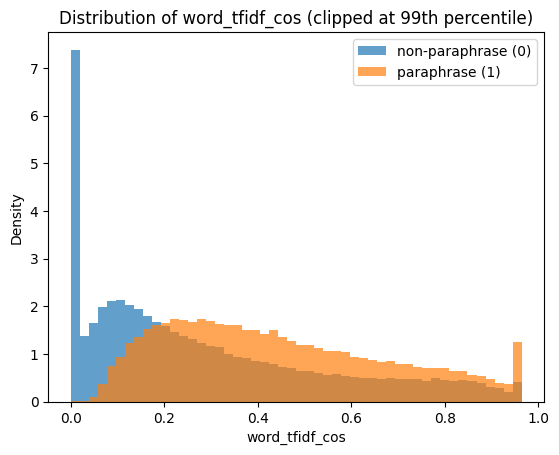

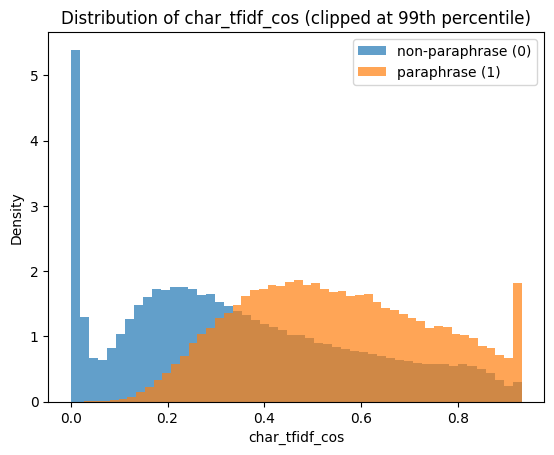

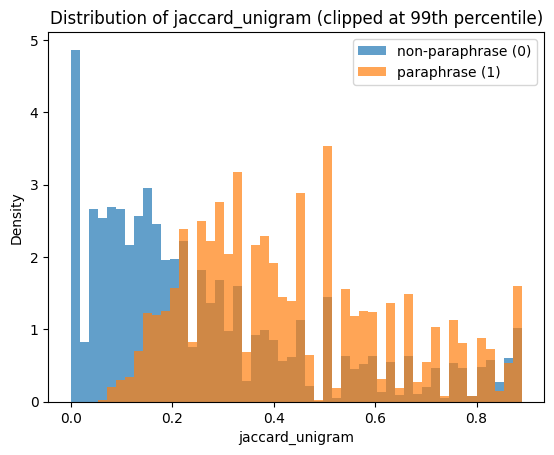

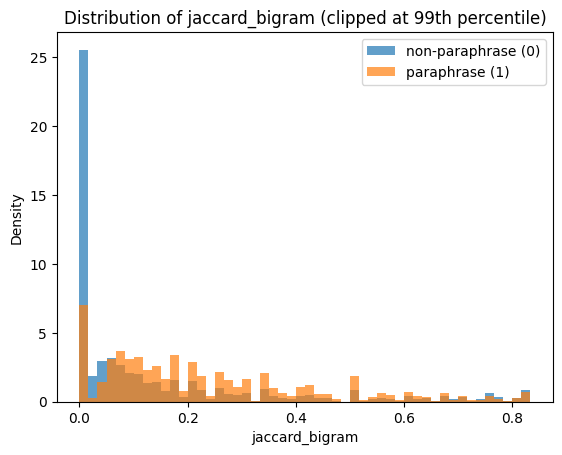

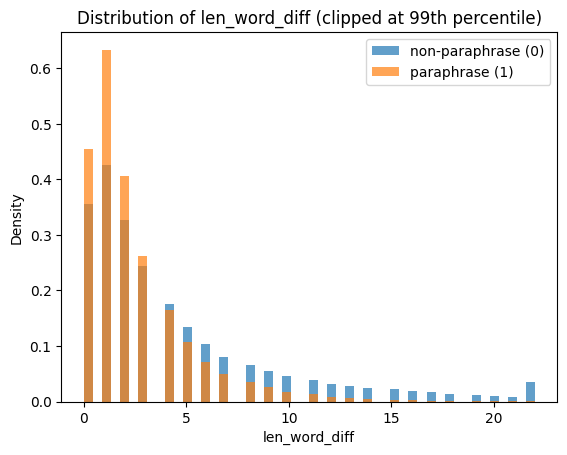

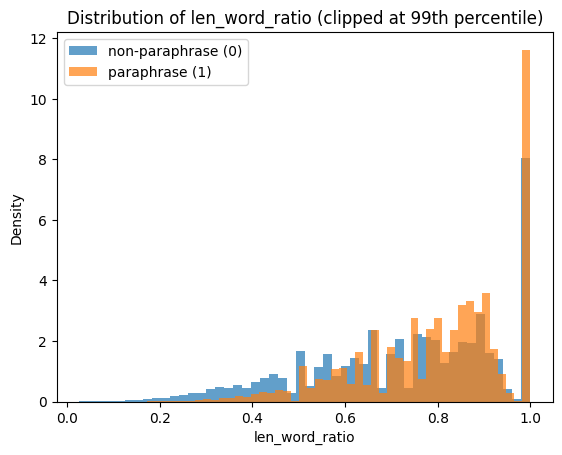

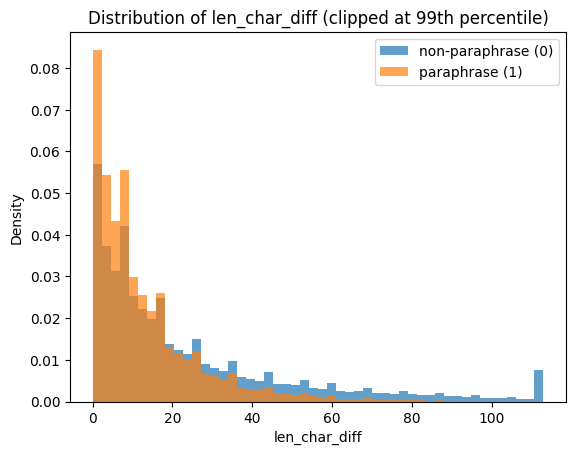

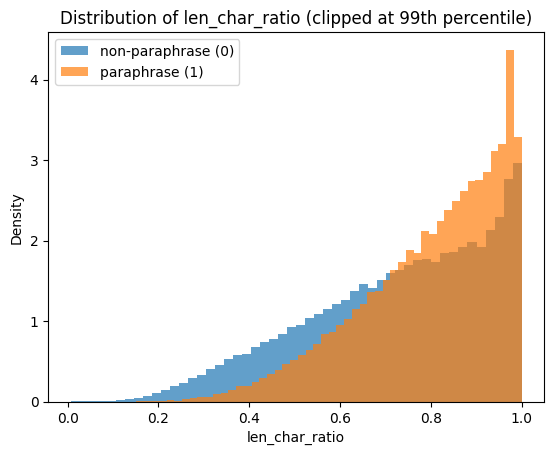

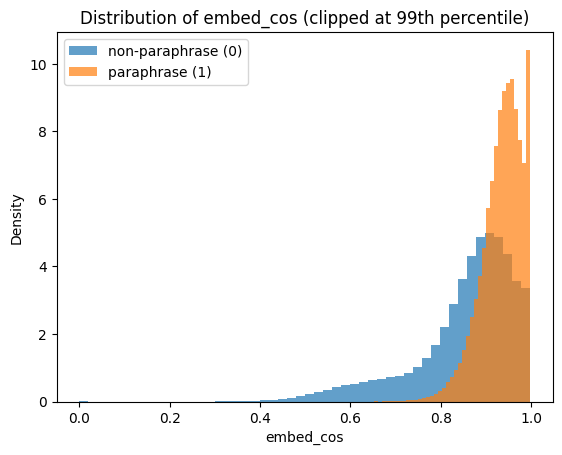

In [119]:
features = [
    "word_tfidf_cos",
    "char_tfidf_cos",
    "jaccard_unigram",
    "jaccard_bigram",
    "len_word_diff",
    "len_word_ratio",
    "len_char_diff",
    "len_char_ratio",
    "embed_cos",
]

plot_feature_distributions(df_test_run, features)


## 4. Model Training Pipeline

In this section, we implement and run the experimental framework used to systematically evaluate different paraphrase detection pipelines. Rather than training a single model, we design a configurable pipeline that allows controlled combinations of feature sets, feature extractor configurations, and classification algorithms. This setup enables comprehensive comparison across a wide range of design choices under a unified evaluation protocol.

Each pipeline is defined by three components:
1. **Feature Set** – a selected combination of similarity features (e.g., lexical overlap, length-based features, embeddings).
2. **Feature Extractor Configuration** – specific parameter settings for the extractors used to compute those features (e.g., TF-IDF n-gram ranges, embedding dimensions).
3. **Classifier Configuration** – a machine learning model and its corresponding hyperparameters.

All configurations are specified declaratively using structured configuration objects. This design allows new features, extractors, or classifiers to be added without modifying the core training logic and ensures that experiments remain reproducible.

### 4.1. Pipeline Configuration

#### 4.1.1. Feature Catalog

The feature catalog serves as a centralized registry that maps high-level feature names to their corresponding extractor types and output columns. It defines which extractor is responsible for computing each feature and how the resulting feature values are represented. This abstraction allows feature sets to be specified declaratively without coupling them directly to implementation details.

In [120]:
FEATURE_CATALOG = {
    # --- Similarity via TF-IDF cosine (word-level) ---
    "word_tfidf_cos": {
        "name": "Word TF-IDF Cosine",
        "extractor_key": "word_tfidf_cos",
        "out_col": "word_tfidf_cos",
        "group": "tfidf_word"
    },

    # --- Similarity via TF-IDF cosine (char-level) ---
    "char_tfidf_cos": {
        "name": "Char TF-IDF Cosine",
        "extractor_key": "char_tfidf_cos",
        "out_col": "char_tfidf_cos",
        "group": "tfidf_char"
    },

    # --- Lexical overlap ---
    "jaccard_unigram": {
        "name": "Jaccard Unigram",
        "extractor_key": "jaccard_overlap",
        "params": {"ngram": 1},
        "out_col": "jaccard_unigram",
        "group": "overlap"
    },
    "jaccard_bigram": {
        "name": "Jaccard Bigram",
        "extractor_key": "jaccard_overlap",
        "params": {"ngram": 2},
        "out_col": "jaccard_bigram",
        "group": "overlap"
    },

    # --- Length/structure ---
    "len_features": {
        "name": "Length Features (char/word diff+ratio)",
        "extractor_key": "length_features",
        "params": {"out_prefix": "len"},
        # This extractor yields multiple columns; pipeline will know which to use
        "out_cols": [
            "len_char_diff", "len_char_ratio",
            "len_word_diff", "len_word_ratio"
        ],
        "group": "length"
    },

    # --- Distributional semantics extension ---
    "embed_cos": {
        "name": "Embedding Cosine (FastText/Word2Vec + TF-IDF weights)",
        "extractor_key": "embed_cos",
        "out_col": "embed_cos",
        "group": "embedding"
    }
}


#### 4.1.2. Extractors
Extractors define how raw text is transformed into numerical features. Each extractor corresponds to a family of related features (e.g., TF-IDF similarity, Jaccard overlap, embeddings) and includes one or more configuration options. By separating extractors from feature sets, the framework supports flexible experimentation with different extraction strategies and parameter choices.

In [121]:
EXTRACTORS = {
    # ---------------------------------------------------------
    # Word TF-IDF cosine extractor configurations
    # ---------------------------------------------------------
    "word_tfidf_cos": {
        "name": "Word TF-IDF Cosine Extractor",
        "function": "word_tfidf_cos_extractor",  # will map string -> callable later
        "fit_on": "train_corpus",                # indicates it must be fitted on train only
        "configs": [
            # Strong baseline
            {"analyzer": "word", "ngram_range": [1, 2], "min_df": 2, "max_df": 0.95, "sublinear_tf": False},

            # Often helps short questions
            {"analyzer": "word", "ngram_range": [1, 1], "min_df": 2, "max_df": 0.95, "sublinear_tf": True},

            # More aggressive n-grams (can help but larger)
            {"analyzer": "word", "ngram_range": [1, 3], "min_df": 2, "max_df": 0.90, "sublinear_tf": True},
        ]
    },

    # ---------------------------------------------------------
    # Char TF-IDF cosine extractor configurations
    # ---------------------------------------------------------
    "char_tfidf_cos": {
        "name": "Char TF-IDF Cosine Extractor",
        "function": "char_tfidf_cos_extractor",
        "fit_on": "train_corpus",
        "configs": [
            {"analyzer": "char", "ngram_range": [3, 5], "min_df": 2, "max_df": 0.95, "sublinear_tf": False},
            {"analyzer": "char", "ngram_range": [4, 6], "min_df": 2, "max_df": 0.95, "sublinear_tf": True},
            # Sometimes helps more with word boundaries (if you want to add it later)
            {"analyzer": "char_wb", "ngram_range": [3, 5], "min_df": 2, "max_df": 0.95, "sublinear_tf": True},
        ]
    },

    # ---------------------------------------------------------
    # Jaccard overlap extractor configurations
    # (stateless, no fitting)
    # ---------------------------------------------------------
    "jaccard_overlap": {
        "name": "Jaccard Overlap Extractor",
        "function": "jaccard_overlap_extractor",
        "fit_on": None,
        "configs": [
            # We keep configs light; the n-gram is specified by FEATURE_CATALOG params
            {"tokenizer": "whitespace"}  # placeholder
        ]
    },

    # ---------------------------------------------------------
    # Length features extractor configurations (stateless)
    # ---------------------------------------------------------
    "length_features": {
        "name": "Length Features Extractor",
        "function": "length_features_extractor",
        "fit_on": None,
        "configs": [
            {"out_prefix": "len"}
        ]
    },

    # ---------------------------------------------------------
    # Embedding cosine extractor configurations
    # (requires training embedding model + fitting idf weights on train only)
    # ---------------------------------------------------------
    "embed_cos": {
        "name": "Embedding Cosine Extractor",
        "function": "embed_cos_extractor",
        "fit_on": "train_corpus",
        "configs": [
            # FastText TF-IDF weighted sentence embedding
            {
                "embed_model": "fasttext",
                "vector_size": 100,
                "window": 5,
                "min_count": 3,
                "sg": 1,
                "negative": 10,
                "epochs": 8,
                "idf_min_df": 2
            },
            # Slightly larger vectors
            {
                "embed_model": "fasttext",
                "vector_size": 200,
                "window": 5,
                "min_count": 3,
                "sg": 1,
                "negative": 10,
                "epochs": 8,
                "idf_min_df": 2
            },
            # Word2Vec variant (no subword OOV robustness, but useful as ablation)
            {
                "embed_model": "word2vec",
                "vector_size": 100,
                "window": 5,
                "min_count": 3,
                "sg": 1,
                "negative": 10,
                "epochs": 8,
                "idf_min_df": 2
            }
        ]
    }
}


#### 4.1.3. Feature Sets
Feature sets specify which features are used together in a given pipeline. Each feature set represents a particular hypothesis about what types of similarity signals are most informative for paraphrase detection, such as lexical overlap, structural similarity, semantic similarity, or combinations thereof. This modular design enables systematic comparison of different feature combinations.

In [122]:
FEATURE_SETS = {
    # Minimal baselines
    "F1_word_only": ["word_tfidf_cos"],
    "F2_char_only": ["char_tfidf_cos"],
    "F3_overlap_only": ["jaccard_unigram", "jaccard_bigram"],
    "F4_length_only": ["len_features"],

    # Strong classical combos
    "F5_word_char": ["word_tfidf_cos", "char_tfidf_cos"],
    "F6_word_overlap": ["word_tfidf_cos", "jaccard_unigram", "jaccard_bigram"],
    "F7_char_overlap": ["char_tfidf_cos", "jaccard_unigram", "jaccard_bigram"],
    "F8_all_non_embed": ["word_tfidf_cos", "char_tfidf_cos", "jaccard_unigram", "jaccard_bigram", "len_features"],

    # Embedding-based variants
    "F9_embed_only": ["embed_cos"],
    "F10_word_embed": ["word_tfidf_cos", "embed_cos"],
    "F11_char_embed": ["char_tfidf_cos", "embed_cos"],
    "F12_full": ["word_tfidf_cos", "char_tfidf_cos", "jaccard_unigram", "jaccard_bigram", "len_features", "embed_cos"]
}


#### 4.1.4. Classifiers
Classifier configurations define the machine learning models and their hyperparameter settings used to train paraphrase detectors. Multiple configurations are provided for each classifier to explore performance–efficiency trade-offs. By treating classifiers as configurable components, the pipeline can evaluate a diverse range of models under the same feature extraction and evaluation protocol.

In [124]:
CLASSIFIERS = {
    "logistic": {
        "name": "Logistic Regression",
        "class": LogisticRegression,
        "configs": [
            {"C": 1.0, "max_iter": 2000, "random_state": 42},
            {"C": 3.0, "max_iter": 2000, "random_state": 42},
            {"C": 10.0, "max_iter": 2000, "random_state": 42},
        ]
    },
    "linear_svm": {
        "name": "Linear SVM",
        "class": LinearSVC,
        "configs": [
            {"C": 1.0, "random_state": 42},
            {"C": 3.0, "random_state": 42},
        ]
    },
    "naive_bayes": {
        "name": "Naive Bayes (Multinomial)",
        "class": MultinomialNB,
        "configs": [
            {"alpha": 1.0},
            {"alpha": 0.5}
        ]
    },
    "random_forest": {
        "name": "Random Forest",
        "class": RandomForestClassifier,
        "configs": [
            {"n_estimators": 200, "max_depth": 12, "random_state": 42, "n_jobs": -1},
            {"n_estimators": 400, "max_depth": 16, "random_state": 42, "n_jobs": -1},
        ]
    },
    "gradient_boosting": {
        "name": "Gradient Boosting",
        "class": GradientBoostingClassifier,
        "configs": [
            {"n_estimators": 200, "learning_rate": 0.1, "max_depth": 3, "random_state": 42},
            {"n_estimators": 400, "learning_rate": 0.05, "max_depth": 3, "random_state": 42},
        ]
    },
    "knn": {
        "name": "KNN",
        "class": KNeighborsClassifier,
        "configs": [
            {"n_neighbors": 5},
            {"n_neighbors": 15},
        ]
    }
}


### 4.2. Pipeline Setup
For each pipeline, features are extracted from the training and test datasets according to the selected configuration. To prevent unintended interactions between experiments, all feature extraction is performed on cloned copies of the original data.

Because many pipelines reuse the same feature extractors and configurations, we employ a caching mechanism to store:
- fitted feature extractors (e.g., TF-IDF vectorizers, embedding models),
- computed feature matrices for individual features.

This significantly reduces redundant computation, especially for expensive steps such as training word embedding models or computing TF-IDF representations.

For each pipeline configuration, the following steps are executed:
1. Extract features from the training and test sets using the specified extractors.
2. Train the selected classifier on the training features.
3. Evaluate the trained model on the test set.

Performance is measured using standard classification metrics, including accuracy, precision, recall, and F1 score. In addition, training time and inference time are recorded to assess computational efficiency. Predictions on the test set are stored to support subsequent error analysis.

All pipeline results, including configuration details and evaluation metrics, are collected into a unified results table for comparison and analysis.

#### 4.2.1. Cache Helper Functions

In [147]:
# ------------------------------------------------------------
# Global caches
# ------------------------------------------------------------
GLOBAL_FIT_CACHE = {
    # fitted objects that depend on train corpus: vectorizers, (embed_model+idf)
    # key -> object
}
GLOBAL_FEATURE_CACHE = {
    # computed feature columns (per df split + config)
    # key -> np.ndarray (feature values)
}

In [146]:
# ------------------------------------------------------------
# Helpers for caching keys
# ------------------------------------------------------------
def _stable_hash(obj) -> str:
    """Stable string key for dict/list configs."""
    return json.dumps(obj, sort_keys=True, default=str)

def _corpus_signature(df_train: pd.DataFrame, q1_col="q1", q2_col="q2") -> str:
    """
    Cheap, stable-ish signature for the training corpus.
    Good enough to avoid accidental reuse across different splits.
    """
    n = len(df_train)
    # small sample for signature (doesn't leak labels; just corpus identity)
    head = (
        df_train[[q1_col, q2_col]]
        .head(50)
        .astype(str)
        .agg("||".join, axis=1)
        .str.cat(sep="##")
    )
    return f"n={n}|head50={hash(head)}"

#### 4.2.2. Extract Features

In [151]:
def extract_features_with_caching(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    features_used,
    chosen_extractors,
    FEATURE_CATALOG,
    q1_col="q1",
    q2_col="q2",
    label_col="label",
    fit_cache=None,
    feature_cache=None,
):
    """
    Clone datasets, extract requested features using the correct extractor+config,
    with feature-wise caching AND fit-object caching (vectorizers, embedding models).

    Parameters
    ----------
    df_train, df_test : pd.DataFrame
        Input train/test dataframes.

    features_used : list[str]
        Feature keys (must exist in FEATURE_CATALOG), e.g.
        ["word_tfidf_cos","char_tfidf_cos","jaccard_unigram","len_features","embed_cos"]

    chosen_extractors : list[tuple]
        List of (extractor_key, config_index, config_dict) for required extractor families.

    FEATURE_CATALOG : dict
        The catalog mapping feature -> extractor_key + params + output columns.

    q1_col, q2_col, label_col : str
        Column names for sentence pair and label.

    fit_cache : dict or None
        Cache for fitted objects (vectorizers, embedding models, idf weights).
        If None, uses GLOBAL_FIT_CACHE.

    feature_cache : dict or None
        Cache for computed feature columns (feature-wise).
        If None, uses GLOBAL_FEATURE_CACHE.

    Returns
    -------
    X_train, y_train, X_test, y_test
        X_* are numpy arrays, y_* are 1D numpy arrays.

    Notes
    -----
    - Caching is done:
        (1) fit_cache: fitted vectorizers / trained embedding model + idf weights per train corpus
        (2) feature_cache: computed column values per (split, feature, extractor_cfg, train_corpus_signature)
    """

    fit_cache = GLOBAL_FIT_CACHE if fit_cache is None else fit_cache
    feature_cache = GLOBAL_FEATURE_CACHE if feature_cache is None else feature_cache

    # Clone to avoid mingling with original dfs
    df_train_run = df_train.copy(deep=True)
    df_test_run = df_test.copy(deep=True)

    # Map extractor_key -> (config_index, config_dict)
    extractor_cfg_map = {ex_key: (idx, cfg) for (ex_key, idx, cfg) in chosen_extractors}

    # Build train corpus (needed for fit-dependent extractors)
    train_corpus = pd.concat([df_train_run[q1_col], df_train_run[q2_col]], axis=0).astype(str)
    corpus_sig = _corpus_signature(df_train_run, q1_col=q1_col, q2_col=q2_col)

    # Utility to get output columns for a feature
    def _feature_out_cols(feat_key):
        meta = FEATURE_CATALOG[feat_key]
        if "out_cols" in meta:
            return list(meta["out_cols"])
        return [meta["out_col"]]

    # --------------------------
    # Extract each requested feature
    # --------------------------
    for feat_key in features_used:
        meta = FEATURE_CATALOG[feat_key]
        extractor_key = meta["extractor_key"]
        feat_params = meta.get("params", {})

        if extractor_key not in extractor_cfg_map:
            raise KeyError(f"Missing extractor config for extractor_key='{extractor_key}' required by feature '{feat_key}'")

        ex_cfg_idx, ex_cfg = extractor_cfg_map[extractor_key]
        ex_cfg_hash = _stable_hash(ex_cfg)

        # Feature-wise cache keys (train/test computed results)
        # Include corpus_sig so the cache is safe across different train splits.
        train_feat_cache_key = f"split=train|corpus={corpus_sig}|feat={feat_key}|ex={extractor_key}|cfg={ex_cfg_hash}|q1={q1_col}|q2={q2_col}"
        test_feat_cache_key  = f"split=test|corpus={corpus_sig}|feat={feat_key}|ex={extractor_key}|cfg={ex_cfg_hash}|q1={q1_col}|q2={q2_col}"

        out_cols = _feature_out_cols(feat_key)

        # If cached, just attach cached arrays as columns and continue
        if train_feat_cache_key in feature_cache and test_feat_cache_key in feature_cache:
            train_vals = feature_cache[train_feat_cache_key]
            test_vals = feature_cache[test_feat_cache_key]

            # train_vals/test_vals can be (n,) or (n, k)
            train_vals = np.asarray(train_vals)
            test_vals = np.asarray(test_vals)

            if train_vals.ndim == 1:
                df_train_run[out_cols[0]] = train_vals
                df_test_run[out_cols[0]] = test_vals
            else:
                for j, col in enumerate(out_cols):
                    df_train_run[col] = train_vals[:, j]
                    df_test_run[col] = test_vals[:, j]
            continue

        # --------------------------
        # Compute feature (not cached)
        # --------------------------
        if extractor_key in ("word_tfidf_cos", "char_tfidf_cos"):
            # Fit vectorizer on train_corpus (cached)
            fit_key = f"fit|corpus={corpus_sig}|ex={extractor_key}|cfg={ex_cfg_hash}"
            if fit_key not in fit_cache:
                vec = TfidfVectorizer(
                    analyzer=ex_cfg.get("analyzer", "word"),
                    ngram_range=tuple(ex_cfg.get("ngram_range", (1, 2))),
                    min_df=ex_cfg.get("min_df", 2),
                    max_df=ex_cfg.get("max_df", 0.95),
                    sublinear_tf=ex_cfg.get("sublinear_tf", False),
                )
                vec.fit(train_corpus)
                fit_cache[fit_key] = vec
            else:
                vec = fit_cache[fit_key]

            # Apply correct extractor
            if extractor_key == "word_tfidf_cos":
                df_train_run = word_tfidf_cos_extractor(df_train_run, vec, q1_col=q1_col, q2_col=q2_col, out_col=out_cols[0])
                df_test_run  = word_tfidf_cos_extractor(df_test_run,  vec, q1_col=q1_col, q2_col=q2_col, out_col=out_cols[0])
            else:
                df_train_run = char_tfidf_cos_extractor(df_train_run, vec, q1_col=q1_col, q2_col=q2_col, out_col=out_cols[0])
                df_test_run  = char_tfidf_cos_extractor(df_test_run,  vec, q1_col=q1_col, q2_col=q2_col, out_col=out_cols[0])

            # Cache computed columns
            feature_cache[train_feat_cache_key] = df_train_run[out_cols[0]].to_numpy()
            feature_cache[test_feat_cache_key]  = df_test_run[out_cols[0]].to_numpy()

        elif extractor_key == "jaccard_overlap":
            # Stateless -> no fit caching needed
            ngram = feat_params.get("ngram", 1)
            df_train_run = jaccard_overlap_extractor(df_train_run, ngram=ngram, q1_col=q1_col, q2_col=q2_col, out_col=out_cols[0])
            df_test_run  = jaccard_overlap_extractor(df_test_run,  ngram=ngram, q1_col=q1_col, q2_col=q2_col, out_col=out_cols[0])

            feature_cache[train_feat_cache_key] = df_train_run[out_cols[0]].to_numpy()
            feature_cache[test_feat_cache_key]  = df_test_run[out_cols[0]].to_numpy()

        elif extractor_key == "length_features":
            # Stateless -> no fit caching needed
            # length_features_extractor typically outputs multiple columns at once
            out_prefix = ex_cfg.get("out_prefix", feat_params.get("out_prefix", "len"))

            df_train_run = length_features_extractor(df_train_run, q1_col=q1_col, q2_col=q2_col, out_col=out_prefix)
            df_test_run  = length_features_extractor(df_test_run,  q1_col=q1_col, q2_col=q2_col, out_col=out_prefix)

            # Ensure expected out_cols exist (based on FEATURE_CATALOG)
            for c in out_cols:
                if c not in df_train_run.columns:
                    raise KeyError(f"Expected length feature column '{c}' not found. Check FEATURE_CATALOG / extractor out_prefix.")

            # Cache as matrix (n, k)
            feature_cache[train_feat_cache_key] = df_train_run[out_cols].to_numpy()
            feature_cache[test_feat_cache_key]  = df_test_run[out_cols].to_numpy()

        elif extractor_key == "embed_cos":
            # Fit/training is expensive -> cache embedding model + idf weights
            fit_key = f"fit|corpus={corpus_sig}|ex=embed_cos|cfg={ex_cfg_hash}"

            if fit_key not in fit_cache:
                embed_model_type = ex_cfg.get("embed_model", "fasttext").lower()
                vector_size = ex_cfg.get("vector_size", 100)
                window = ex_cfg.get("window", 5)
                min_count = ex_cfg.get("min_count", 3)
                sg = ex_cfg.get("sg", 1)
                negative = ex_cfg.get("negative", 10)
                epochs = ex_cfg.get("epochs", 8)
                idf_min_df = ex_cfg.get("idf_min_df", 2)

                # Train tokens from train_corpus
                train_tokens = [simple_tokenize(s) for s in train_corpus.tolist()]

                if embed_model_type == "fasttext":
                    model = FastText(
                        vector_size=vector_size,
                        window=window,
                        min_count=min_count,
                        workers=ex_cfg.get("workers", 4),
                        sg=sg,
                        negative=negative,
                        epochs=epochs,
                    )
                    model.build_vocab(train_tokens)
                    model.train(train_tokens, total_examples=len(train_tokens), epochs=model.epochs)
                elif embed_model_type == "word2vec":
                    model = Word2Vec(
                        sentences=train_tokens,
                        vector_size=vector_size,
                        window=window,
                        min_count=min_count,
                        workers=ex_cfg.get("workers", 4),
                        sg=sg,
                        negative=negative,
                        epochs=epochs,
                    )
                else:
                    raise ValueError(f"Unknown embed_model type: {embed_model_type}")

                # Fit TF-IDF weights for IDF (train only)
                tfidf_weights = TfidfVectorizer(
                    tokenizer=simple_tokenize,
                    preprocessor=None,
                    token_pattern=None,
                    min_df=idf_min_df
                )
                tfidf_weights.fit(train_corpus)

                idf = dict(zip(tfidf_weights.get_feature_names_out(), tfidf_weights.idf_))
                default_idf = float(np.mean(list(idf.values()))) if len(idf) else 1.0

                fit_cache[fit_key] = {
                    "model": model,
                    "idf": idf,
                    "default_idf": default_idf,
                }

            fitted = fit_cache[fit_key]
            model = fitted["model"]
            idf = fitted["idf"]
            default_idf = fitted["default_idf"]

            # Apply embed_cos extractor
            df_train_run = embed_cos_extractor(
                df_train_run,
                text_model=model,
                idf=idf,
                default_idf=default_idf,
                simple_tokenize=simple_tokenize,
                q1_col=q1_col,
                q2_col=q2_col,
                out_col=out_cols[0],
            )
            df_test_run = embed_cos_extractor(
                df_test_run,
                text_model=model,
                idf=idf,
                default_idf=default_idf,
                simple_tokenize=simple_tokenize,
                q1_col=q1_col,
                q2_col=q2_col,
                out_col=out_cols[0],
            )

            feature_cache[train_feat_cache_key] = df_train_run[out_cols[0]].to_numpy()
            feature_cache[test_feat_cache_key]  = df_test_run[out_cols[0]].to_numpy()

        else:
            raise ValueError(f"Unsupported extractor_key: {extractor_key}")

    # --------------------------
    # Build X/y arrays
    # --------------------------
    # Expand requested features into column list
    selected_cols = []
    for feat_key in features_used:
        for c in _feature_out_cols(feat_key):
            selected_cols.append(c)

    X_train = df_train_run[selected_cols].to_numpy(dtype=np.float32)
    y_train = df_train_run[label_col].to_numpy()
    X_test  = df_test_run[selected_cols].to_numpy(dtype=np.float32)
    y_test  = df_test_run[label_col].to_numpy()

    return X_train, y_train, X_test, y_test

#### 4.2.3. Train Pipeline

In [204]:
def train_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    clf_class,
    clf_config,
    average="binary",
):
    """
    Train + evaluate a classifier on provided features.

    Parameters
    ----------
    X_train, y_train, X_test, y_test
        Train/test feature matrices and labels.

    clf_class : type
        Class object of the classifier (e.g., LogisticRegression, LinearSVC, ...)

    clf_config : dict
        Hyperparameters for clf_class.

    average : str
        Averaging strategy for precision/recall/f1.
        For QQP (binary labels), keep "binary".

    Returns
    -------
    result : dict
        Dictionary containing:
          - train_time_sec
          - inference_time_sec
          - accuracy, precision, recall, f1
    """

    # ------------------------------------------------------------
    # Small adjustment: some classifiers benefit strongly from scaling
    # (LogReg, LinearSVM, KNN). Others (trees, NB) do not require it.
    # We'll automatically add StandardScaler for the ones that need it.
    # ------------------------------------------------------------
    needs_scaling = clf_class.__name__ in {"LogisticRegression", "LinearSVC", "KNeighborsClassifier"}

    if needs_scaling:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", clf_class(**clf_config))
        ])
    else:
        model = clf_class(**clf_config)

    # Ensure labels are 1D arrays
    y_train = np.asarray(y_train).ravel()
    y_test = np.asarray(y_test).ravel()

    # ------------------------------------------------------------
    # Train timing
    # ------------------------------------------------------------
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    train_time = time.perf_counter() - t0

    # ------------------------------------------------------------
    # Inference timing
    # ------------------------------------------------------------
    t1 = time.perf_counter()
    y_pred = model.predict(X_test)
    inference_time = time.perf_counter() - t1

    # ------------------------------------------------------------
    # Metrics
    # ------------------------------------------------------------
    acc = accuracy_score(y_test, y_pred)

    # zero_division=0 avoids errors if a model predicts only one class
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec = recall_score(y_test, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=0)

    return {
        "train_time_sec": float(train_time),
        "inference_time_sec": float(inference_time),
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "y_pred": y_pred,
        "y_true": y_test
    }

#### 4.2.4. Run All Pipelines

In [205]:
def run_all_pipelines(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    FEATURE_SETS=FEATURE_SETS,
    FEATURE_CATALOG=FEATURE_CATALOG,
    EXTRACTORS=EXTRACTORS,
    CLASSIFIERS=CLASSIFIERS,
    limit=None,
):
    """
    Run all combinations of pipelines:
      feature_set × extractor_configs × classifier_configs

    Parameters
    ----------
    df_train, df_test : pd.DataFrame
        Input train/test dataframes.
        
    limit : int or None
        Maximum number of pipelines to run.
        None = run all pipelines.

    Returns
    -------
    all_results : list[dict]
        Each dict is a "row" containing pipeline training result
    """
    
    print("\n🚀 Training all pipeline combinations...\n")

    all_results = []
    count = 0

    for fs_id, feature_keys in FEATURE_SETS.items():

        # --------------------------------------------------
        # Determine which extractor families are required
        # --------------------------------------------------
        extractor_keys_needed = []
        for feat_key in feature_keys:
            extractor_key = FEATURE_CATALOG[feat_key]["extractor_key"]
            if extractor_key not in extractor_keys_needed:
                extractor_keys_needed.append(extractor_key)

        # --------------------------------------------------
        # Build config space for required extractors
        # --------------------------------------------------
        extractor_config_spaces = []
        for ex_key in extractor_keys_needed:
            ex_cfgs = EXTRACTORS[ex_key]["configs"]
            extractor_config_spaces.append(
                [(ex_key, i, cfg) for i, cfg in enumerate(ex_cfgs)]
            )

        # --------------------------------------------------
        # Cartesian product of extractor configurations
        # --------------------------------------------------
        for chosen_extractors in itertools.product(*extractor_config_spaces):

            # --------------------------------------------------
            # Iterate over classifiers and their configurations
            # --------------------------------------------------
            for clf_key, clf_meta in CLASSIFIERS.items():
                for clf_idx, clf_cfg in enumerate(clf_meta["configs"]):
                    # Stop if limit is reached
                    if limit is not None and count >= limit:
                        print(f"\n⚠️  Reached limit of {limit} pipelines")
                        return all_results

                    # Print pipeline configs
                    ex_part = " | ".join(
                        f"{ex_key}[cfg#{idx}]"
                        for (ex_key, idx, _) in chosen_extractors
                    )
                    clf_part = f"{clf_key}[cfg#{clf_idx}]"

                    print(f"PIPELINE #{count + 1}")
                    print(f"  feature_set \t\t: {fs_id}")
                    print(f"  features \t\t: {feature_keys}")
                    print(f"  extractors \t\t: {ex_part}")
                    print(f"  classifier \t\t: {clf_part}")
                    
                    # Store pipeline result in a flat-ish structure
                    # so it can be exported later.
                    row = {
                        "pipeline_id": count + 1,
                        "feature_set_id": fs_id,
                        "features": "|".join(feature_keys),  # CSV-friendly

                        # Classifier info
                        "classifier_key": clf_key,
                        "classifier_name": clf_meta["name"],
                        "classifier_config_index": clf_idx,
                        "classifier_config": str(clf_cfg),

                        # Extractor info (store as compact strings)
                        "extractor_keys": "|".join([ex_key for (ex_key, _, _) in chosen_extractors]),
                        "extractor_config_indices": "|".join([str(idx) for (_, idx, _) in chosen_extractors]),
                        "extractor_configs": "|".join([str(cfg) for (_, _, cfg) in chosen_extractors]),
                    }

                    # --------------------------------------------------
                    # Extract features and train model
                    # --------------------------------------------------
                    X_train, y_train, X_test, y_test = extract_features_with_caching(
                        df_train=df_train,
                        df_test=df_test,
                        features_used=list(feature_keys),
                        chosen_extractors=list(chosen_extractors),
                        FEATURE_CATALOG=FEATURE_CATALOG,
                        q1_col="q1",
                        q2_col="q2",
                        label_col="label",
                    )
                    
                    metrics = train_pipeline(
                        X_train, y_train, X_test, y_test,
                        clf_class=clf_meta["class"],
                        clf_config=clf_cfg
                    )
                    
                    # Append metrics to the row
                    row.update(metrics)

                    print(f"  ✅ accuracy \t\t: {metrics['accuracy']*100:.2f}%")
                    print(f"  ⚡ inference time \t: {metrics['inference_time_sec']:.2f} seconds")
                    print("-" * 80)
                    all_results.append(row)
                    count += 1

    print(f"\n✅ Completed {count} pipelines!\n")
    return all_results


#### 4.2.5. Generate Comparison Report

In [206]:
def generate_comparison_report(results, save_file_name="pipeline_comparison_results.csv", sort_by="f1"):
    """
    Generate a simple console comparison report + save results to CSV.

    Assumes each result row contains at least:
      - accuracy, precision, recall, f1
      - train_time_sec, inference_time_sec
      - feature_set_id, features
      - extractor_keys, extractor_config_indices
      - classifier_key, classifier_config_index

    Parameters
    ----------
    results : list[dict]
        Output of run_all_pipelines(...)

    save_file_name : str
        CSV filename to save results.

    sort_by : str
        Metric column to rank pipelines by. Common: "f1", "accuracy".
    """
    print("📊 Generating comparison report...\n")

    df = pd.DataFrame(results)

    # Safety: if empty results
    if df.empty:
        print("⚠️ No results to report.")
        return df

    # Ensure expected columns exist (avoid KeyError in printing)
    required = ["accuracy", "precision", "recall", "f1", "train_time_sec", "inference_time_sec"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required metric columns in results: {missing}")

    # Sort best-first
    if sort_by not in df.columns:
        sort_by = "f1" if "f1" in df.columns else "accuracy"
    df = df.sort_values(sort_by, ascending=False).reset_index(drop=True)

    # Pick best performers
    best = df.iloc[0]
    fastest_train = df.loc[df["train_time_sec"].idxmin()]
    fastest_infer = df.loc[df["inference_time_sec"].idxmin()]

    def pipeline_str(r):
        """Compact pipeline description for printing."""
        feat = r.get("feature_set_id", "?")
        clf = f"{r.get('classifier_key','?')}[cfg#{r.get('classifier_config_index','?')}]"
        ex  = f"{r.get('extractor_keys','?')}|cfgs={r.get('extractor_config_indices','?')}"
        return f"{feat} → {ex} → {clf}"

    print("=" * 80)
    print("🏆 BEST PERFORMERS")
    print("=" * 80)

    print(f"\n🎯 Best by {sort_by.upper()}: {best[sort_by]:.4f}")
    print(f"   {pipeline_str(best)}")
    print(f"   Acc={best['accuracy']:.4f}  P={best['precision']:.4f}  R={best['recall']:.4f}  F1={best['f1']:.4f}")

    print(f"\n⚡ Fastest Training: {fastest_train['train_time_sec']:.4f}s")
    print(f"   {pipeline_str(fastest_train)}")
    print(f"   Acc={fastest_train['accuracy']:.4f}  P={fastest_train['precision']:.4f}  R={fastest_train['recall']:.4f}  F1={fastest_train['f1']:.4f}")

    print(f"\n💨 Fastest Inference: {fastest_infer['inference_time_sec']:.6f}s (total on test set)")
    print(f"   {pipeline_str(fastest_infer)}")
    print(f"   Acc={fastest_infer['accuracy']:.4f}  P={fastest_infer['precision']:.4f}  R={fastest_infer['recall']:.4f}  F1={fastest_infer['f1']:.4f}")

    # Top 10 table
    topn = min(10, len(df))
    print(f"\n{'=' * 80}")
    print(f"📌 TOP {topn} PIPELINES BY {sort_by.upper()}")
    print("=" * 80)

    header = f"{'Rank':<6} {'FeatureSet':<16} {'Classifier':<20} {'F1':<8} {'Acc':<8} {'Train(s)':<10} {'Infer(s)':<10}"
    print(header)
    print("-" * len(header))

    for i in range(topn):
        r = df.iloc[i]
        clf = f"{r.get('classifier_key','?')}[cfg#{r.get('classifier_config_index','?')}]"
        print(
            f"{i+1:<6} {str(r.get('feature_set_id','?')):<16} {clf:<20} "
            f"{r['f1']:<8.4f} {r['accuracy']:<8.4f} {r['train_time_sec']:<10.4f} {r['inference_time_sec']:<10.6f}"
        )

    # Save full results
    df.to_csv(save_file_name, index=False)
    print(f"\n✅ Results saved to: {save_file_name}\n")

    return df

#### 4.2.6. Saving Caches

Initializing feature extractors and computing feature values can be computationally expensive, particularly for components that require fitting on the training corpus (e.g., TF-IDF vectorizers and embedding models). To avoid repeating this cost across runs, we persist both the fitted extractor cache and the computed feature cache to disk.

Saving these caches allows subsequent experiments to reuse previously computed results, significantly reducing total runtime and enabling faster iteration when modifying pipeline configurations or evaluation settings.

In [ ]:
def save_caches(
    feature_cache,
    fit_cache,
    out_dir="cache",
):
    """
    Persist GLOBAL_FEATURE_CACHE and GLOBAL_FIT_CACHE to disk.

    Parameters
    ----------
    feature_cache : dict
        Cache storing computed feature arrays.

    fit_cache : dict
        Cache storing fitted objects (vectorizers, embedding models, idf).

    out_dir : str
        Directory to save cache files.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    joblib.dump(feature_cache, out_dir / "feature_cache.joblib")
    joblib.dump(fit_cache, out_dir / "fit_cache.joblib")

    print(f"✅ Saved feature cache ({len(feature_cache)}) entries")
    print(f"✅ Saved fit cache ({len(fit_cache)}) entries")


In [222]:
save_caches(GLOBAL_FEATURE_CACHE, GLOBAL_FIT_CACHE)

✅ Saved feature cache (24) entries
✅ Saved fit cache (9) entries


#### 4.2.7. Loading Caches

Previously saved caches can be loaded at the beginning of an experiment to restore fitted extractors and extracted features without recomputation. This is especially useful when rerunning experiments in a new session or after code modifications that do not affect feature extraction.

By reusing cached artifacts, the pipeline maintains consistency across runs while achieving substantial performance gains in terms of both training and feature extraction time.

In [163]:
def load_caches(
    out_dir="cache",
):
    """
    Load cached feature results and fitted objects from disk.

    Returns
    -------
    feature_cache : dict
    fit_cache : dict
    """
    out_dir = Path(out_dir)

    feature_cache = joblib.load(out_dir / "feature_cache.joblib")
    fit_cache = joblib.load(out_dir / "fit_cache.joblib")

    print(f"✅ Loaded feature cache ({len(feature_cache)}) entries")
    print(f"✅ Loaded fit cache ({len(fit_cache)}) entries")

    return feature_cache, fit_cache


In [ ]:
GLOBAL_FEATURE_CACHE, GLOBAL_FIT_CACHE = load_caches()

### 4.3. Run Experiments

In [220]:
all_results = run_all_pipelines(df_train=df_train, df_test=df_test)


🚀 Training all pipeline combinations...

PIPELINE #1
  feature_set 		: F1_word_only
  features 		: ['word_tfidf_cos']
  extractors 		: word_tfidf_cos[cfg#0]
  classifier 		: logistic[cfg#0]
  ✅ accuracy 		: 62.58%
  ⚡ inference time 	: 0.00 seconds
--------------------------------------------------------------------------------
PIPELINE #2
  feature_set 		: F1_word_only
  features 		: ['word_tfidf_cos']
  extractors 		: word_tfidf_cos[cfg#0]
  classifier 		: logistic[cfg#1]
  ✅ accuracy 		: 62.58%
  ⚡ inference time 	: 0.00 seconds
--------------------------------------------------------------------------------
PIPELINE #3
  feature_set 		: F1_word_only
  features 		: ['word_tfidf_cos']
  extractors 		: word_tfidf_cos[cfg#0]
  classifier 		: logistic[cfg#2]
  ✅ accuracy 		: 62.58%
  ⚡ inference time 	: 0.00 seconds
--------------------------------------------------------------------------------
PIPELINE #4
  feature_set 		: F1_word_only
  features 		: ['word_tfidf_cos']
  extractors 	

In [231]:
generate_comparison_report(all_results)

📊 Generating comparison report...

🏆 BEST PERFORMERS

🎯 Best by F1: 0.7069
   F12_full → word_tfidf_cos|char_tfidf_cos|jaccard_overlap|length_features|embed_cos|cfgs=2|2|0|0|0 → random_forest[cfg#1]
   Acc=0.7760  P=0.6839  R=0.7314  F1=0.7069

⚡ Fastest Training: 0.0133s
   F9_embed_only → embed_cos|cfgs=0 → naive_bayes[cfg#0]
   Acc=0.6308  P=0.0000  R=0.0000  F1=0.0000

💨 Fastest Inference: 0.001672s (total on test set)
   F2_char_only → char_tfidf_cos|cfgs=2 → logistic[cfg#1]
   Acc=0.6858  P=0.5890  R=0.4928  F1=0.5366

📌 TOP 10 PIPELINES BY F1
Rank   FeatureSet       Classifier           F1       Acc      Train(s)   Infer(s)  
------------------------------------------------------------------------------------
1      F12_full         random_forest[cfg#1] 0.7069   0.7760   93.0150    1.842027  
2      F12_full         random_forest[cfg#1] 0.7057   0.7758   58.0719    1.530093  
3      F12_full         random_forest[cfg#1] 0.7055   0.7755   55.8045    1.147568  
4      F12_full    

,pipeline_id,feature_set_id,features,classifier_key,classifier_name,classifier_config_index,classifier_config,extractor_keys,extractor_config_indices,extractor_configs,train_time_sec,inference_time_sec,accuracy,precision,recall,f1,y_pred,y_true
0,1010,F12_full,word_tfidf_cos|char_tfidf_cos|jaccard_unigram|...,random_forest,Random Forest,1,"{'n_estimators': 400, 'max_depth': 16, 'random...",word_tfidf_cos|char_tfidf_cos|jaccard_overlap|...,2|2|0|0|0,"{'analyzer': 'word', 'ngram_range': [1, 3], 'm...",93.015015,1.842027,0.776044,0.683929,0.731414,0.706875,"[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."
1,945,F12_full,word_tfidf_cos|char_tfidf_cos|jaccard_unigram|...,random_forest,Random Forest,1,"{'n_estimators': 400, 'max_depth': 16, 'random...",word_tfidf_cos|char_tfidf_cos|jaccard_overlap|...,2|0|0|0|1,"{'analyzer': 'word', 'ngram_range': [1, 3], 'm...",58.071864,1.530093,0.775837,0.684776,0.727931,0.705694,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."
2,932,F12_full,word_tfidf_cos|char_tfidf_cos|jaccard_unigram|...,random_forest,Random Forest,1,"{'n_estimators': 400, 'max_depth': 16, 'random...",word_tfidf_cos|char_tfidf_cos|jaccard_overlap|...,2|0|0|0|0,"{'analyzer': 'word', 'ngram_range': [1, 3], 'm...",55.804459,1.147568,0.775466,0.683905,0.728578,0.705535,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."
3,1023,F12_full,word_tfidf_cos|char_tfidf_cos|jaccard_unigram|...,random_forest,Random Forest,1,"{'n_estimators': 400, 'max_depth': 16, 'random...",word_tfidf_cos|char_tfidf_cos|jaccard_overlap|...,2|2|0|0|1,"{'analyzer': 'word', 'ngram_range': [1, 3], 'm...",128.412091,1.975695,0.775178,0.683242,0.729047,0.705402,"[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."
4,1036,F12_full,word_tfidf_cos|char_tfidf_cos|jaccard_unigram|...,random_forest,Random Forest,1,"{'n_estimators': 400, 'max_depth': 16, 'random...",word_tfidf_cos|char_tfidf_cos|jaccard_overlap|...,2|2|0|0|2,"{'analyzer': 'word', 'ngram_range': [1, 3], 'm...",145.483056,3.819765,0.774766,0.682765,0.728355,0.704823,"[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,566,F10_word_embed,word_tfidf_cos|embed_cos,naive_bayes,Naive Bayes (Multinomial),1,{'alpha': 0.5},word_tfidf_cos|embed_cos,2|2,"{'analyzer': 'word', 'ngram_range': [1, 3], 'm...",0.014981,0.002860,0.630801,0.000000,0.000000,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."
1036,643,F11_char_embed,char_tfidf_cos|embed_cos,naive_bayes,Naive Bayes (Multinomial),0,{'alpha': 1.0},char_tfidf_cos|embed_cos,1|2,"{'analyzer': 'char', 'ngram_range': [4, 6], 'm...",0.015847,0.003398,0.630801,0.000000,0.000000,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."
1037,71,F2_char_only,char_tfidf_cos,naive_bayes,Naive Bayes (Multinomial),0,{'alpha': 1.0},char_tfidf_cos,2,"{'analyzer': 'char_wb', 'ngram_range': [3, 5],...",0.018936,0.002945,0.630801,0.000000,0.000000,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."
1038,72,F2_char_only,char_tfidf_cos,naive_bayes,Naive Bayes (Multinomial),1,{'alpha': 0.5},char_tfidf_cos,2,"{'analyzer': 'char_wb', 'ngram_range': [3, 5],...",0.016158,0.003205,0.630801,0.000000,0.000000,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, ..."


## 5. Error Analysis

While aggregate evaluation metrics provide a high-level view of model performance, they do not fully explain *why* certain predictions succeed or fail. In this section, we conduct a detailed error analysis to better understand the behavior of selected paraphrase detection pipelines.

Specifically, we analyze errors from multiple perspectives. First, we examine confusion matrices of representative pipelines to understand the balance between false positives and false negatives. This analysis highlights systematic biases, such as over-reliance on surface-level similarity or difficulty capturing deeper semantic equivalence.

Next, we perform feature-level error analysis by comparing the distributions of individual features for correctly and incorrectly classified examples. This helps identify which similarity signals are most informative and where they break down.

Together, these analyses provide insight into the strengths and limitations of the feature-based approach and motivate potential improvements explored in the discussion and future work sections.


### 5.1. Confusion Matrix Analysis

To further contextualize the confusion matrices, we examine the configurations and performance metrics of the three representative pipelines: the best-performing pipeline by F1 score, the fastest training pipeline, and the fastest inference pipeline. These pipelines illustrate distinct trade-offs between accuracy, efficiency, and modeling capacity.

---

#### Best Pipeline (Highest F1 Score)

The best-performing pipeline combines a comprehensive set of features—including word-level TF-IDF similarity, character-level TF-IDF similarity, Jaccard overlap, length-based features, and embedding cosine similarity—and uses a Random Forest classifier.

This pipeline achieves an F1 score of 0.7069 with balanced precision (0.6839) and recall (0.7314), indicating strong overall performance. The confusion matrix shows that most paraphrase pairs are correctly identified, with a relatively low number of false negatives compared to the faster baselines. At the same time, false positives are present but remain controlled.

The balanced error profile reflects the complementary nature of the feature set: lexical overlap features help identify surface-level similarity, while embedding-based features improve semantic recall. The Random Forest classifier further benefits from its ability to model non-linear interactions among heterogeneous features.

---

#### Fastest Training Pipeline

The fastest training pipeline relies solely on embedding cosine similarity and uses a Naive Bayes classifier. Although this configuration yields extremely low training time, it completely fails to detect paraphrases, resulting in zero precision, recall, and F1 score.

The confusion matrix reveals that the model predicts all instances as non-paraphrases, leading to a large number of false negatives. This behavior suggests that the independence assumptions of Naive Bayes are poorly suited for continuous embedding-based similarity features, causing the model to collapse to a trivial majority-class solution.

This pipeline highlights that computational efficiency alone is insufficient and that model–feature compatibility is crucial for effective paraphrase detection.

---

#### Fastest Inference Pipeline

The fastest inference pipeline uses only character-level TF-IDF cosine similarity combined with logistic regression. This pipeline achieves moderate accuracy (0.6858) but lower recall (0.4928) and F1 score (0.5366) compared to the best-performing configuration.

The confusion matrix indicates a conservative prediction strategy, with a substantial number of false negatives. While character-level similarity is effective at capturing surface-level resemblance and allows for very fast inference, it lacks the semantic expressiveness needed to identify paraphrases with limited lexical overlap.

This pipeline demonstrates that lightweight features and linear classifiers can provide efficient inference but struggle to capture deeper semantic equivalence.

---

#### Summary

The confusion-matrix-driven analysis reveals clear trade-offs across pipeline designs:
- Rich, multi-feature pipelines combined with expressive classifiers achieve the best balance between precision and recall.
- Extremely fast pipelines may converge to trivial or overly conservative solutions.
- Feature diversity and classifier choice play a critical role in mitigating false negatives without introducing excessive false positives.

These observations reinforce the importance of jointly considering accuracy and efficiency when designing paraphrase detection systems.


In [227]:
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot a confusion matrix as a heatmap with counts.

    Layout:
        [[TN, FP],
         [FN, TP]]
    """
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    # Axis labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Non-Paraphrase (0)", "Paraphrase (1)"])
    ax.set_yticklabels(["Non-Paraphrase (0)", "Paraphrase (1)"])
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # Annotate cells with values
    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, f"{cm[i, j]}",
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.tight_layout()
    plt.show()

In [228]:
def confusion_matrix_analysis(all_results):
    """
    Visualize confusion matrices for:
      - Best pipeline (by F1)
      - Fastest training pipeline
      - Fastest inference pipeline
    """
    df = pd.DataFrame(all_results)

    if df.empty:
        print("⚠️ No results available.")
        return

    # Identify pipelines
    best = df.sort_values("f1", ascending=False).iloc[0]
    fastest_train = df.loc[df["train_time_sec"].idxmin()]
    fastest_infer = df.loc[df["inference_time_sec"].idxmin()]

    def pipeline_desc(r):
        return (
            f"{r['feature_set_id']} | "
            f"{r['classifier_key']}[cfg#{r['classifier_config_index']}]"
        )

    print("\n📊 Confusion Matrix Analysis\n")

    # ---------------------------
    # Best pipeline
    # ---------------------------
    print("🏆 Best Pipeline (by F1)")
    print(pipeline_desc(best))
    plot_confusion_matrix(
        best["y_true"],
        best["y_pred"],
        title="Best Pipeline – Confusion Matrix"
    )

    # ---------------------------
    # Fastest training
    # ---------------------------
    print("⚡ Fastest Training Pipeline")
    print(pipeline_desc(fastest_train))
    plot_confusion_matrix(
        fastest_train["y_true"],
        fastest_train["y_pred"],
        title="Fastest Training – Confusion Matrix"
    )

    # ---------------------------
    # Fastest inference
    # ---------------------------
    print("💨 Fastest Inference Pipeline")
    print(pipeline_desc(fastest_infer))
    plot_confusion_matrix(
        fastest_infer["y_true"],
        fastest_infer["y_pred"],
        title="Fastest Inference – Confusion Matrix"
    )



📊 Confusion Matrix Analysis

🏆 Best Pipeline (by F1)
F12_full | random_forest[cfg#1]


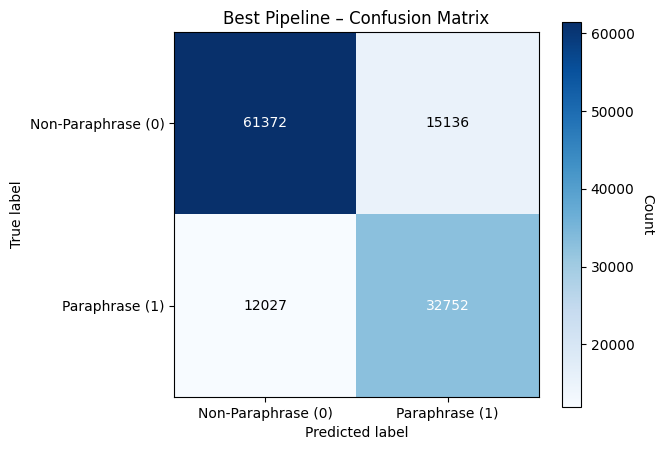

⚡ Fastest Training Pipeline
F9_embed_only | naive_bayes[cfg#0]


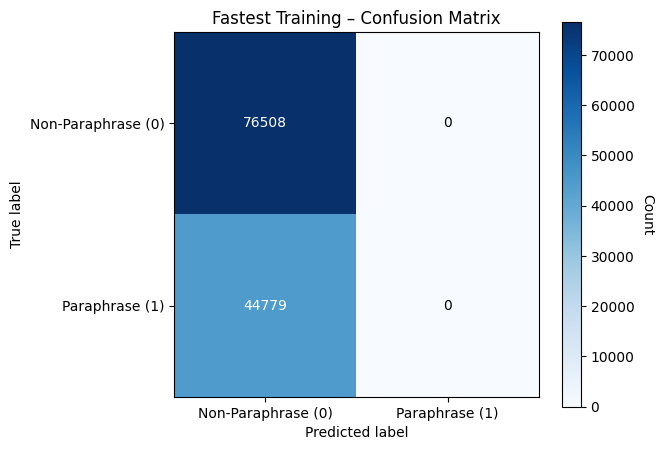

💨 Fastest Inference Pipeline
F2_char_only | logistic[cfg#1]


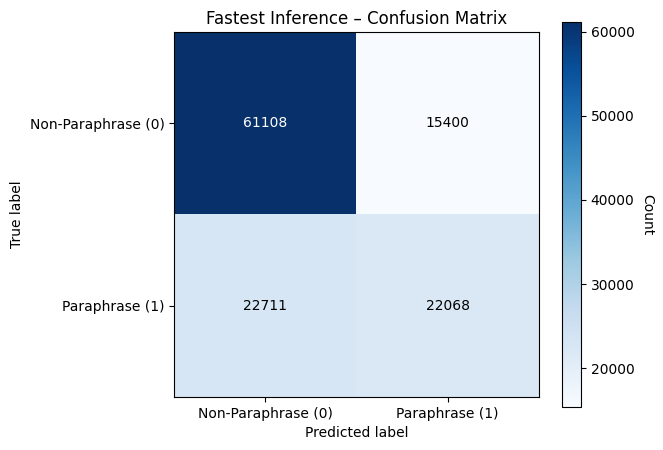

In [229]:
confusion_matrix_analysis(all_results)

### 5.2. Feature-Level Error Analysis

This subsection analyzes how individual features behave for **correct predictions versus errors**, focusing on three representative pipelines:
the **best-performing pipeline**, the **fastest training pipeline**, and the **fastest inference pipeline**.  
By examining feature distributions, we identify which signals are reliable, which are ambiguous, and why certain models fail.

---

#### Best Pipeline (Highest F1 Score)

The best-performing pipeline combines **lexical similarity**, **structural cues**, and **semantic embeddings**, but the feature-level error distributions reveal that many errors occur precisely where features appear strong, rather than weak.

**Embedding cosine similarity** shows substantial overlap between correct predictions and errors. While correct predictions are slightly more spread toward lower cosine values, **errors are heavily concentrated at very high cosine similarity (≈ 0.85–1.0)**. This indicates that high semantic similarity alone is not sufficient for correct classification. Many false predictions arise from semantically very similar question pairs that are nevertheless misclassified, suggesting ambiguity or label noise in the dataset.

**Word and character TF-IDF cosine similarities** display a similar pattern. Errors are not concentrated at low similarity; instead, they frequently occur at **moderate to high TF-IDF cosine values**, overlapping strongly with correct predictions. This implies that surface-level lexical overlap is a necessary but unreliable signal: questions with high lexical similarity are not always paraphrases, and the model struggles to separate true paraphrases from near-duplicates or topically related non-paraphrases.

**Jaccard overlap features** (both unigram and bigram) further reinforce this observation. While extremely low overlap is more common among correct non-paraphrase predictions, **errors span a wide range of overlap values**, including medium and high overlaps. In particular, bigram Jaccard shows that errors often occur even when there is substantial phrase overlap, highlighting the limitation of n-gram matching for capturing semantic equivalence.

**Length-based features** (word and character ratios and differences) show only weak discrimination. Errors and correct predictions largely overlap across the full range of ratios and differences. Slight tendencies exist—errors are marginally more frequent when sentence lengths are very similar—but overall, these features act only as weak auxiliary cues rather than decisive factors.

Overall, contrary to a "low-similarity causes errors" narrative, the plots clearly show that **many errors occur in regions of high feature confidence**: high embedding cosine, high TF-IDF similarity, and moderate-to-high n-gram overlap. This suggests that the dominant failure mode of the best pipeline is **over-confidence on superficially or semantically similar question pairs that are not true paraphrases**. The remaining errors likely require deeper semantic reasoning, discourse understanding, or external knowledge that cannot be captured by similarity-based features alone.

---

#### Fastest Training Pipeline

The fastest training pipeline uses **only embedding cosine similarity** as its feature and applies a lightweight **Naive Bayes** classifier, resulting in extremely low training time.

From the feature distribution, we observe that **both correct predictions (blue) and errors (orange) are tightly concentrated at very high embedding cosine values (≈ 0.85–1.0)**, with substantial overlap. In fact, errors are even more sharply peaked near the maximum cosine range. This indicates that high semantic similarity is common for *both* paraphrase and non-paraphrase pairs in the dataset.

Because the model relies on a single, highly overlapping feature, it fails to learn a discriminative boundary. As reflected in the confusion matrix, the classifier effectively collapses into predicting the majority class, resulting in **zero recall for paraphrases** and an F1 score of zero.

This behavior highlights a key limitation:

> **Embedding-based semantic similarity alone is insufficient for paraphrase detection, especially when used with a simple classifier and without supporting lexical or structural features.**

While this pipeline is computationally efficient, its performance trade-off makes it unsuitable for practical paraphrase detection tasks without additional features or stronger modeling capacity.

---

#### Fastest Inference Pipeline

The fastest inference pipeline relies exclusively on **character-level TF-IDF cosine similarity**, prioritizing minimal inference latency over representational richness.

From the feature distribution, we observe a clear separation at the extremes:  
- **Very low cosine values** are almost exclusively associated with correct non-paraphrase predictions.  
- **Very high cosine values** are more likely to yield correct paraphrase predictions.

However, the **mid-range similarity region (approximately 0.3–0.7)** shows substantial overlap between correct predictions (blue) and errors (orange). Errors are especially concentrated in this region, indicating that the classifier struggles to resolve ambiguous cases based on character-level overlap alone.

This behavior reflects the nature of character TF-IDF features: they are effective at capturing **surface-form similarity** (shared substrings, spelling patterns) but are insensitive to deeper semantic relationships. As a result, paraphrases that involve rephrasing or synonym substitution, as well as non-paraphrases with coincidental character overlap, are more prone to misclassification.

Overall, this pipeline achieves reasonable accuracy with **excellent inference speed**, but its reliance on a single surface-level feature limits its ability to robustly distinguish paraphrases in linguistically diverse cases.

---

#### Summary

Feature-level error analysis across the evaluated pipelines highlights several consistent and instructive patterns:

- **Semantic embedding similarity** provides a strong but noisy signal. High cosine similarity appears frequently in both correct predictions and errors, showing that semantic closeness alone does not reliably distinguish paraphrases from non-paraphrases in the QQP dataset.
- **Lexical similarity features** (word- and character-level TF-IDF, Jaccard overlap) are effective at identifying pairs with shared surface forms, but they struggle in cases of substantial rewording or synonym substitution.
- **Character-level features** are particularly efficient and robust at the extremes of similarity, but ambiguity in the mid-range leads to a high concentration of errors.
- **Length-based features** act primarily as auxiliary signals, helping to reduce errors when sentence pairs differ significantly in structure, but they offer limited discriminative power in isolation.
- **Speed-optimized pipelines** clearly expose the limitations of relying on a single feature type, often collapsing to trivial decision boundaries despite excellent computational efficiency.

Overall, these results reinforce a key insight:  
> **Effective paraphrase detection depends on feature complementarity.**  
Combining semantic, lexical, and structural signals allows models to resolve ambiguities that any individual feature type cannot address on its own.


#### 5.2.1. Helper function

In [215]:
def expand_feature_columns(feature_keys, FEATURE_CATALOG):
    """
    Convert pipeline 'features' list (feature keys) into the actual feature columns
    present in df_test (e.g., len_features -> [len_char_diff, len_char_ratio, ...]).
    """
    cols = []
    for fk in feature_keys:
        meta = FEATURE_CATALOG[fk]
        if "out_cols" in meta:
            cols.extend(meta["out_cols"])
        else:
            cols.append(meta["out_col"])
    return cols

#### 5.2.2. Plot Correct vs Error Distributions For One Pipeline

In [216]:
def plot_correct_vs_error_distributions(
    df_test_feat,
    y_true,
    y_pred,
    feature_cols,
    title_prefix="",
    bins=60,
    clip_quantile=0.99
):
    """
    Plot density histograms of each feature for Correct vs Error predictions.

    Parameters
    ----------
    df_test_feat : pd.DataFrame
        Test dataframe that already contains the feature columns required by this pipeline.

    y_true, y_pred : array-like
        Ground-truth and predicted labels for the test set.

    feature_cols : list[str]
        Actual feature column names to plot.

    clip_quantile : float or None
        Percentile clipping (visualization only) to reduce outlier dominance.
    """
    df_err = df_test_feat.copy()
    df_err["correct"] = (np.asarray(y_true) == np.asarray(y_pred))

    for feat in feature_cols:
        if feat not in df_err.columns:
            # Skip missing columns (in case a pipeline didn't compute something)
            continue

        # Optional clipping for visualization (helps heavy-tailed length diffs)
        if clip_quantile is not None:
            vmax = df_err[feat].quantile(clip_quantile)
            x_correct = df_err[df_err["correct"]][feat].clip(upper=vmax)
            x_error   = df_err[~df_err["correct"]][feat].clip(upper=vmax)
            suffix = f" (clipped @ {int(clip_quantile*100)}th pct)"
        else:
            x_correct = df_err[df_err["correct"]][feat]
            x_error   = df_err[~df_err["correct"]][feat]
            suffix = ""

        plt.figure()
        plt.hist(x_correct, bins=bins, density=True, alpha=0.6, label="Correct")
        plt.hist(x_error,   bins=bins, density=True, alpha=0.6, label="Errors")
        plt.title(f"{title_prefix}{feat}: Correct vs Errors{suffix}")
        plt.xlabel(feat)
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()


#### 5.2.3. Analysis

In [232]:
def feature_level_error_analysis_top3(
    all_results,
    df_train,
    df_test,
    FEATURE_CATALOG,
    sort_by="f1",
    bins=60,
    clip_quantile=0.99
):
    """
    Plot feature distributions (Correct vs Errors) for:
      - Best pipeline (by sort_by)
      - Fastest training pipeline
      - Fastest inference pipeline

    For each pipeline, it extracts the pipeline's features on df_test again
    (via extract_features_with_caching / your build_xy function) so that the
    required feature columns exist in df_test_feat.
    """
    df_res = pd.DataFrame(all_results)

    # Pick the 3 pipelines
    best = df_res.sort_values(sort_by, ascending=False).iloc[0]
    fastest_train = df_res.loc[df_res["train_time_sec"].idxmin()]
    fastest_infer = df_res.loc[df_res["inference_time_sec"].idxmin()]

    picks = [
        ("BEST", best),
        ("FASTEST_TRAIN", fastest_train),
        ("FASTEST_INFER", fastest_infer),
    ]

    for tag, row in picks:
        # Recover pipeline config info
        feature_keys = row["features"].split("|") if isinstance(row["features"], str) else row["features"]

        # Rebuild chosen_extractors list from stored strings
        # extractor_keys like "word_tfidf_cos|jaccard_overlap"
        # extractor_config_indices like "0|1"
        # extractor_configs like "{...}|{...}"
        ex_keys = row["extractor_keys"].split("|")
        ex_idxs = [int(x) for x in row["extractor_config_indices"].split("|")]
        ex_cfgs = [eval(x) for x in row["extractor_configs"].split("|")]

        chosen_extractors = list(zip(ex_keys, ex_idxs, ex_cfgs))

        # Build feature-enriched clones using cached extraction
        # (we only need the df_test with features, so use the same extractor pipeline)
        _, _, X_test, _ = extract_features_with_caching(
            df_train=df_train,
            df_test=df_test,
            features_used=list(feature_keys),
            chosen_extractors=chosen_extractors,
            FEATURE_CATALOG=FEATURE_CATALOG,
            q1_col="q1",
            q2_col="q2",
            label_col="label",
        )

        # y_true / y_pred for this pipeline should be in all_results
        y_true = row["y_true"]
        y_pred = row["y_pred"]

        # For plotting we need the feature columns; easiest is to rebuild df_test_feat:
        # We'll construct df_test_feat by cloning df_test and then filling columns from X_test
        # using the correct feature column order.
        feature_cols = expand_feature_columns(feature_keys, FEATURE_CATALOG)

        df_test_feat = df_test.copy()
        # Put X_test2 into those columns (in the same order build_xy created them)
        for j, col in enumerate(feature_cols):
            df_test_feat[col] = X_test[:, j]

        title_prefix = f"[{tag}] "

        plot_correct_vs_error_distributions(
            df_test_feat=df_test_feat,
            y_true=y_true,
            y_pred=y_pred,
            feature_cols=feature_cols,
            title_prefix=title_prefix,
            bins=bins,
            clip_quantile=clip_quantile
        )


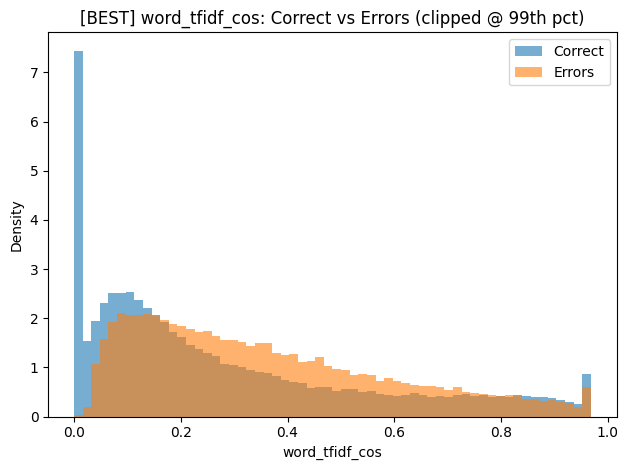

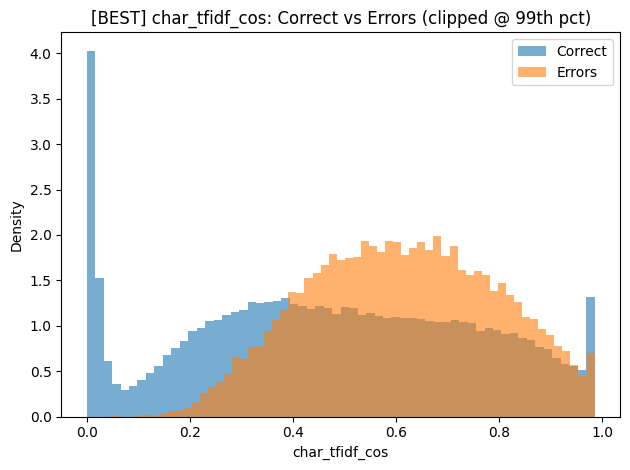

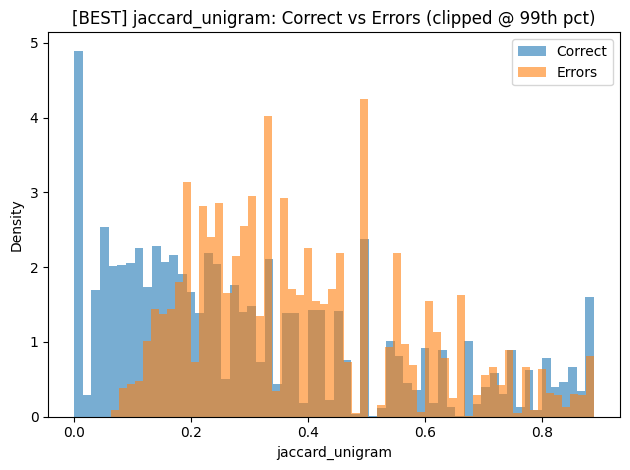

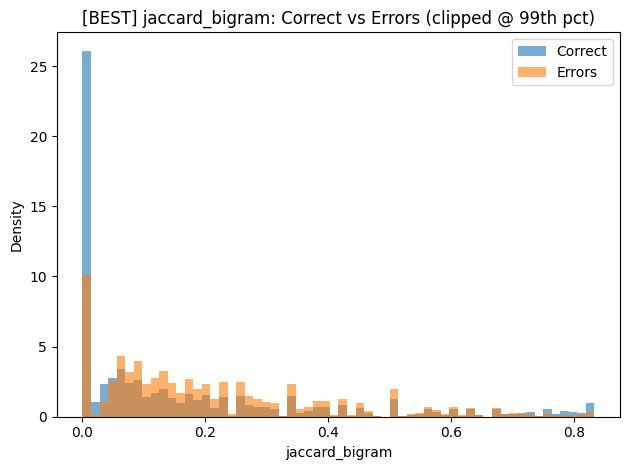

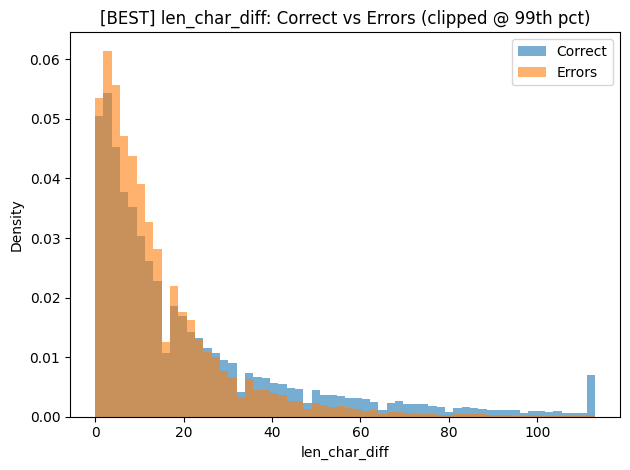

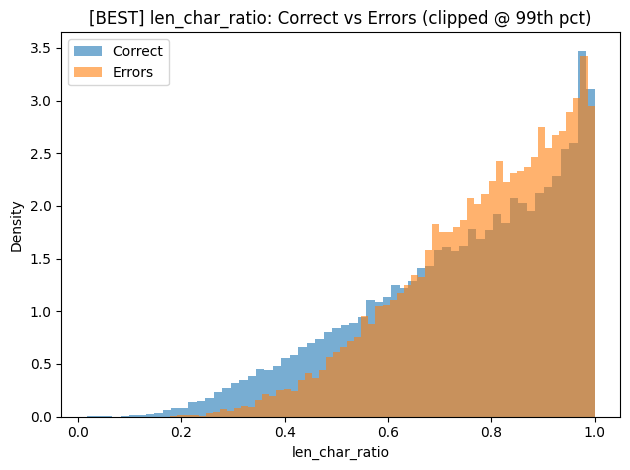

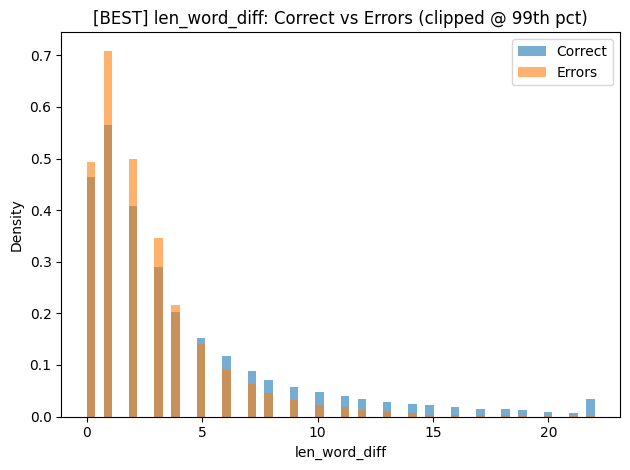

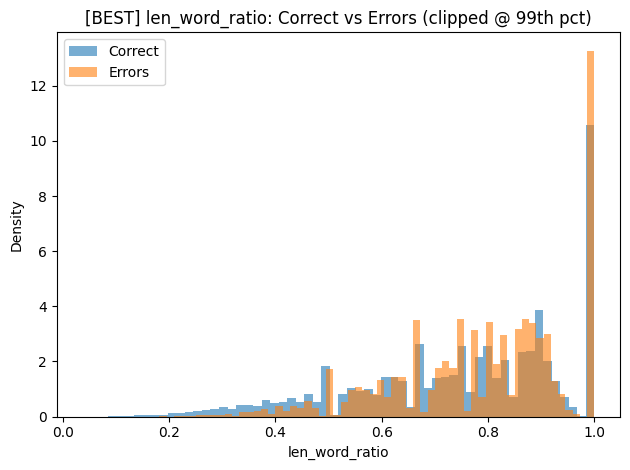

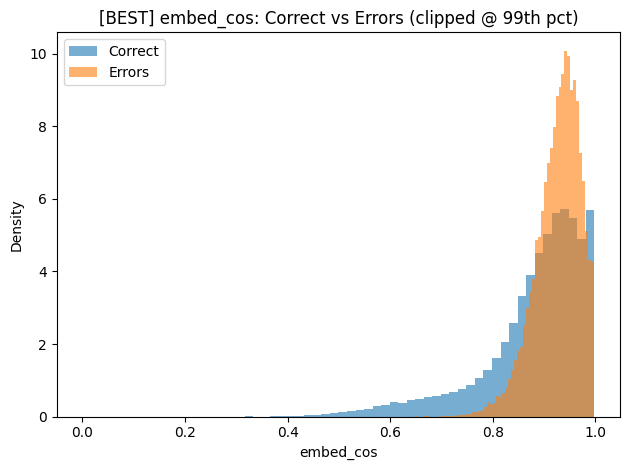

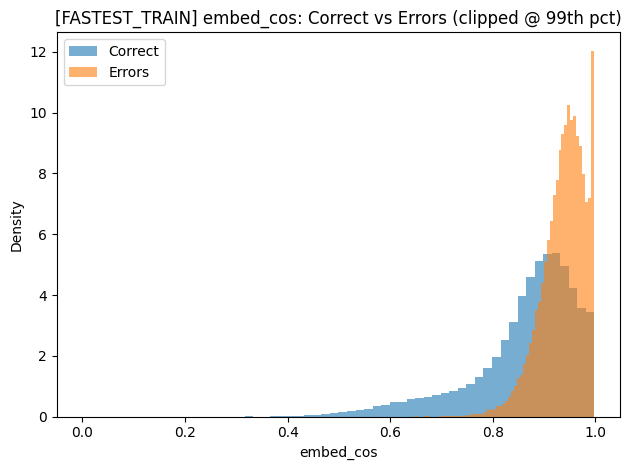

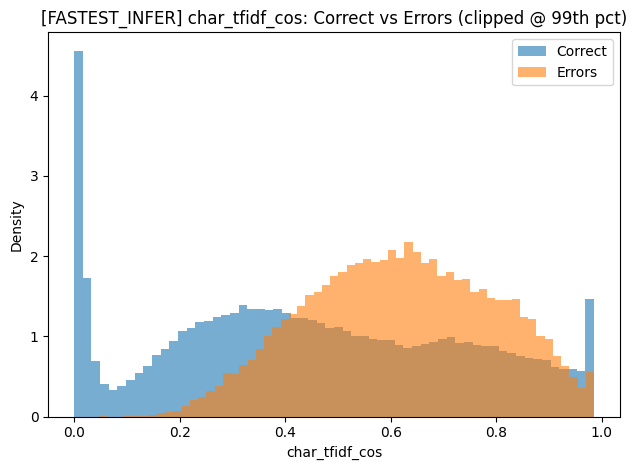

In [234]:
feature_level_error_analysis_top3(
    all_results=all_results,
    df_train=df_train,
    df_test=df_test,
    FEATURE_CATALOG=FEATURE_CATALOG,
    sort_by="f1",
    bins=60,
    clip_quantile=0.99
)

## 6. Conclusion

In this notebook, we explored **paraphrase detection** as a real-world NLP task using the Quora Question Pairs dataset, with a focus on building an interpretable and modular pipeline rather than relying on large pre-trained sentence encoders.

We implemented a diverse set of **feature extraction techniques**, including lexical similarity (word- and character-level TF-IDF), n-gram overlap (Jaccard similarity), structural cues (length-based features), and semantic representations (TF-IDF–weighted FastText embeddings). By systematically combining these features with multiple classifiers, we evaluated a large number of pipeline configurations under a unified experimental framework.

Our experiments show that:
- No single feature type is sufficient for robust paraphrase detection.
- Semantic embeddings provide valuable information but are highly ambiguous when used alone.
- Lexical and structural features significantly improve discrimination, particularly when combined with semantic signals.
- Pipelines optimized purely for speed reveal important failure modes that are masked in more complex models.
- The best-performing pipeline achieves a strong balance between precision and recall by integrating **semantic, lexical, and structural features**.

Beyond performance metrics, detailed **confusion-matrix and feature-level error analysis** provided insight into *why* certain pipelines succeed or fail, highlighting the importance of interpretability in NLP system design.

Overall, this project demonstrates that effective paraphrase detection can be achieved with **lightweight, explainable features** and classical machine learning models, provided that feature complementarity is carefully considered.
